# Business Understanding

This investigation uses North Carolina School Report Card data on school performance. The North Carolina School Report Card reports on performance of all North Carolina public, charter, and alternative schools. This data has been made public so parents and others can compare schools, districts, and state level analytics to see how a school is performing. The State of North Carolina makes the data readily available and provides readymade online SAS analytic reports for less technical users. Below we merge three of the available datasets to conduct our analysis. They are named: 1) 'All_Data_By_School_Final', 2) 'Ec_Pupils_Expanded (2017 Race Compositions by School)', and 3) '1516testresults_masking_removed'. Here is a breif summary of each data set:

**All_Data_By_School_Final** - This data set has 2575 records and 293 attributes. Each record is for an active North Carolina school in 2016. The attributes have been collected from multiple data sets on statistical profiles and school report cards of North Carolina schools. The variety of attributes cover a wide spectrum of data for exploring factors contributing to school performance.

**Ec_Pupils_Expanded (2017 Race Compositions by School)** - This data set has 2447 records and 30 attributes. The attributes break down the racial composition of each school's student body. Each record represents a North Carolina school active in 2017 that choose to gather these metrics. This data can be used to explore the relation between racial demography and school performance.

**1516testresults_masking_removed** - This data set has 39857 records and 12 attributes. Each record contains data on an academic performance metric for a given school active in 2015-2016. For example, schools with students in grade levels 3-8 record EOG (end of grade) or EOC (end of course) metrics. Attributes include a quantile breakdown of the percentage of students in a school's student body performing at that level for a given subject.  


The purpose of this project is to data mine and visualize relevant features contributing to North Carolina school performance. Primary performance metrics include SPG (School Performance Grades) scores, records of which were first gathered in 2013 when state legislation required that every school receive, among other evaluations, an a percentage SPG score and SPG A-F letter grade. With a few special-case exceptions, these evaluations are 80% based on achievement score metrics, and 20% based on a metric of the student body's academic growth. We will rely on the SPG metrics as valid assessments of school performance. If robust correlations between school attributes and performance metrics can be identified, then statistically founded recommendations can be made regarding ways of maintaining and improving school performance.

In the analysis that follows, the primary target variable used in determining factors contributing to school performance will be SPG Score. The analysis zeroes in on a subset of attributes of particular importance to the question of interest. Linear combinations of these attributes are generated using principal component analysis. Next steps will involve building predictive models using principal component regression and partial least squares regression. Ten-fold cross-validation and mean-squared-error metrics will be used in evaluating model performance.

# Data import and Merging

The three data sets were merged on the school unit code value. Because the data sets cover slightly different time periods (across three schools years, 2015 to 2017), and not all schools measured the same information, a small number of attributes will be duplicated to retain the available data for all schools.

In [75]:
#Importing the data

#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#Reading in raw data
schoolData = pd.read_csv('C:/Users/jkras/Desktop/All_Data_By_School_Final.csv',low_memory=False)
testScores = pd.read_csv('C:/Users/jkras/Desktop/1516testresults_masking_removed.csv', low_memory=False)
raceData = pd.read_csv('C:/Users/jkras/Desktop/Ec_Pupils_Expanded (2017 Race Compositions by School).csv',low_memory=False)

#looking at the schoolData before merging for validation
schoolData.info()
print('************************************************************') 
print("schoolData ", schoolData.shape)
print("testScores ", testScores.shape)
print("raceData ", raceData.shape)
print('************************************************************')
pd.set_option('display.max_columns', 500)
schoolData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 293 entries, Year to State_Prin_Exp_Pct_10+_Years
dtypes: float64(255), int64(17), object(21)
memory usage: 5.8+ MB
************************************************************
schoolData  (2579, 293)
testScores  (39857, 12)
raceData  (2446, 30)
************************************************************


,Year,unit_code,street_ad,scity_ad,state_ad,szip_ad,type_cd_txt,Closed_Ind_Text,New_ind_Txt,category_cd,school_type_txt,calendar_only_txt,title1_type_flg,clp_ind_flg,focus_clp_flg,summer_program_flg,asm_no_spg_flg,no_data_spg_flg,esea_status,student_num,lea_avg_student_num,st_avg_student_num,Grad_project_status,stem_flg,Avg_Class_Size_00,Avg_Class_Size_01,Avg_Class_Size_02,Avg_Class_Size_03,Avg_Class_Size_04,Avg_Class_Size_05,Avg_Class_Size_06,Avg_Class_Size_07,Avg_Class_Size_08,Avg_Class_Size_Biology,Avg_Class_Size_EnglishII,Avg_Class_Size_MathI,Avg_Dist_Size_00,Avg_Dist_Size_01,Avg_Dist_Size_02,Avg_Dist_Size_03,Avg_Dist_Size_04,Avg_Dist_Size_05,Avg_Dist_Size_06,Avg_Dist_Size_07,Avg_Dist_Size_08,Avg_Dist_Size_Biology,Avg_Dist_Size_EnglishII,Avg_Dist_Size_MathI,Avg_State_Size_00,Avg_State_Size_01,Avg_State_Size_02,Avg_State_Size_03,Avg_State_Size_04,Avg_State_Size_05,Avg_State_Size_06,Avg_State_Size_07,Avg_State_Size_08,Avg_State_Size_Biology,Avg_State_Size_EnglishII,Avg_State_Size_MathI,total_expense_num,salary_expense_pct,benefits_expense_pct,services_expense_pct,supplies_expense_pct,instruct_equip_exp_pct,other_expense_pct,federal_perpupil_num,local_perpupil_num,state_perpupil_num,lea_total_expense_num,lea_salary_expense_pct,lea_benefits_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,lea_instruct_equip_exp_pct,lea_other_expense_pct,lea_federal_perpupil_num,lea_local_perpupil_num,lea_state_perpupil_num,st_total_expense_num,st_salary_expense_pct,st_benefits_expense_pct,st_services_expense_pct,st_supplies_expense_pct,st_instruct_equip_exp_pct,st_other_expense_pct,st_federal_perpupil_num,st_local_perpupil_num,st_state_perpupil_num,SPG Grade,SPG Score,Reading SPG Grade,Reading SPG Score,Math SPG Grade,Math SPG Score,EVAAS Growth Status,EVAAS Growth Score,Overall Achievement Score,Read Score,Math Score,Science Score,Math I Score,English II Score,Biology Score,The ACT Score,ACT WorkKeys Score,Math Course Rigor Score,Cohort Graduation Rate Standard Score,State Gap Compared,GCE_ALL_School_Pct,GCE_LEP_School_Pct,GCE_PRM_School_Pct,GCE_RPF_School_Pct,GCE_SWD_School_Pct,PASSED_EOG_School_Pct,PASSED_LAA_School_Pct,PASSED_RTA_School_Pct,PROMOTED_School_Pct,RETAINED_School_Pct,GCE_ALL_Dist_Pct,GCE_LEP_Dist_Pct,GCE_PRM_Dist_Pct,GCE_RPF_Dist_Pct,GCE_SWD_Dist_Pct,PASSED_EOG_Dist_Pct,PASSED_LAA_Dist_Pct,PASSED_RTA_Dist_Pct,PROMOTED_Dist_Pct,RETAINED_Dist_Pct,GCE_ALL_State_Pct,GCE_LEP_State_Pct,GCE_PRM_State_Pct,GCE_RPF_State_Pct,GCE_SWD_State_Pct,PASSED_EOG_State_Pct,PASSED_LAA_State_Pct,PASSED_RTA_State_Pct,PROMOTED_State_Pct,RETAINED_State_Pct,sat_avg_score_num,lea_sat_avg_score_num,st_sat_avg_score_num,nat_sat_avg_score_num,sat_participation_pct,lea_sat_participation_pct,st_sat_participation_pct,nat_sat_participation_pct,esea_attendance,lea_esea_attendance,ap_participation_pct,lea_ap_participation_pct,st_ap_participation_pct,ap_pct_3_or_above,lea_ap_pct_3_or_above,st_ap_pct_3_or_above,ib_participation_pct,lea_ib_participation_pct,st_ib_participation_pct,ib_pct_4_or_above,lea_ib_pct_4_or_above,st_ib_pct_4_or_above,AP_Courses_Offered,total_specialized_courses,ap_ib_courses,cte_courses,univ_college_courses,lea_total_specialized_courses,lea_ap_ib_courses,lea_cte_courses,lea_univ_college_courses,st_total_specialized_courses,st_ap_ib_courses,st_cte_courses,st_univ_college_courses,sch_percent_college_enrolled_16_mos_post_grad,One_Yr_College_Complete_wi_2_yrs_Enrolled_2012,avg_daily_attend_pct,crime_per_c_num,short_susp_per_c_num,long_susp_per_c_num,expelled_per_c_num,ttl_crimes_num,stud_internet_comp_num,lea_avg_daily_attend_pct,lea_crime_per_c_num,lea_short_susp_per_c_num,lea_long_susp_per_c_num,lea_expelled_per_c_num,lea_stud_internet_comp_num,st_avg_daily_attend_pct,st_crime_per_c_num,st_short_susp_per_c_num,st_long_susp_per_c_num,st_expelled_per_c_num,st_stud_internet_comp_num,digital_media_pct,Byod,grades_BYOD,avg_age_media_collection,1_to_1_access,books_per_student,grades_1_to_1_access,lea_avg_age_media_collection,lea_books_p

In [76]:
#Now going to merge the datasets

#pivot table for merging all Percent GLP for all Subjects of a given School Code (i.e., unit_code)
piv_test = pd.pivot_table(testScores, values='Percent GLP',index=['School Code'],columns='Subject')

#rename pivot table index from School Code to unit_code
piv_test.index.name = 'unit_code'

#append _GLP suffix to GLP score columns of pivot table
piv_test.columns = [str(col) + '_GLP' for col in piv_test.columns]

#reset pivot table index, so unit_code becomes a column (for later merging)
piv_alltest = piv_test.reset_index()

#merge with main data set
schoolData_alltest = schoolData.merge(piv_alltest,how='left',on='unit_code')

#list of race columns from racial composition dataset
racecols = ['Indian Male', 'Indian Female', 'Asian Male',
       'Asian Female', 'Hispanic Male', 'Hispanic Female', 'Black Male',
       'Black Female', 'White Male', 'White Female', 'Pacific Island Male',
       'Pacific Island Female', 'Two or  More Male', 'Two or  More Female',
       'Total', 'White', 'Black', 'Hispanic', 'Indian', 'Asian',
       'Pacific Island', 'Two or More', 'White_Pct', 'Majority_Minority']

#append _RACE suffix to racial composition column names
racecols_renamed = [str(col) + '_RACE' for col in racecols]

#zip together old and new racial composition column names for easy renaming
racecol_rename_dict = {i:j for i,j in zip(racecols,racecols_renamed)}

#rename columns of racial composition dataset so suffixing is evident when subsequently merged
raceData.rename(index=str, columns=racecol_rename_dict,inplace=True)

#ensure that unit_code column is of type string
raceData['unit_code'] = raceData['unit_code'].apply(str)

#append 0's to unit_code values in racial composition dataset, so no duplicates are created when merging (thanks Ranga!)
for i,j in raceData.iterrows():
    
    if len(raceData['unit_code'][i]) == 5: #only unit_code values with less than 5 digits need 0 prefixing to match up in the merge
        raceData.loc[i, 'unit_code'] = '0' + raceData['unit_code'][i]
        
#merge the racial composition dataset with the testScores and main schoolData datasets
schoolData_testRace = schoolData_alltest.merge(raceData,how='left',on='unit_code')

#subset the testScores dataset so that SBE District info can also be merged below
region_df = testScores[['School Code','SBE District']]

#rename the index of the subsetted dataframe so the unit_code column name will match during merging
region_df.rename(index=str, columns={'School Code':'unit_code'},inplace=True)

#drop all the duplicate combinations of column values to ensure no duplicated records are created when merging
region_df_unique = region_df.drop_duplicates()

#merge the subsetted dataframe of only unique column value combinations with the other merged dataframe
schoolData_testRaceRegion = schoolData_testRace.merge(region_df_unique,how='left',on='unit_code')

#check the shape of the resulting totally merged dataframe

print('************************************************************') 
print("schoolData_testRaceRegion ", schoolData_testRaceRegion.shape)

print('************************************************************') 

schoolData_testRaceRegion.head()

#NB: this approach to merging throws a 'SettingWithCopyWarning'

#display all column names if desired
#with pd.option_context('display.max_seq_items', None):
#    print(schoolData_testRaceRegion.columns)


C:\Users\jkras\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


************************************************************
schoolData_testRaceRegion  (2579, 352)
************************************************************


,Year_x,unit_code,street_ad,scity_ad,state_ad,szip_ad,type_cd_txt,Closed_Ind_Text,New_ind_Txt,category_cd,school_type_txt,calendar_only_txt,title1_type_flg,clp_ind_flg,focus_clp_flg,summer_program_flg,asm_no_spg_flg,no_data_spg_flg,esea_status,student_num,lea_avg_student_num,st_avg_student_num,Grad_project_status,stem_flg,Avg_Class_Size_00,Avg_Class_Size_01,Avg_Class_Size_02,Avg_Class_Size_03,Avg_Class_Size_04,Avg_Class_Size_05,Avg_Class_Size_06,Avg_Class_Size_07,Avg_Class_Size_08,Avg_Class_Size_Biology,Avg_Class_Size_EnglishII,Avg_Class_Size_MathI,Avg_Dist_Size_00,Avg_Dist_Size_01,Avg_Dist_Size_02,Avg_Dist_Size_03,Avg_Dist_Size_04,Avg_Dist_Size_05,Avg_Dist_Size_06,Avg_Dist_Size_07,Avg_Dist_Size_08,Avg_Dist_Size_Biology,Avg_Dist_Size_EnglishII,Avg_Dist_Size_MathI,Avg_State_Size_00,Avg_State_Size_01,Avg_State_Size_02,Avg_State_Size_03,Avg_State_Size_04,Avg_State_Size_05,Avg_State_Size_06,Avg_State_Size_07,Avg_State_Size_08,Avg_State_Size_Biology,Avg_State_Size_EnglishII,Avg_State_Size_MathI,total_expense_num,salary_expense_pct,benefits_expense_pct,services_expense_pct,supplies_expense_pct,instruct_equip_exp_pct,other_expense_pct,federal_perpupil_num,local_perpupil_num,state_perpupil_num,lea_total_expense_num,lea_salary_expense_pct,lea_benefits_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,lea_instruct_equip_exp_pct,lea_other_expense_pct,lea_federal_perpupil_num,lea_local_perpupil_num,lea_state_perpupil_num,st_total_expense_num,st_salary_expense_pct,st_benefits_expense_pct,st_services_expense_pct,st_supplies_expense_pct,st_instruct_equip_exp_pct,st_other_expense_pct,st_federal_perpupil_num,st_local_perpupil_num,st_state_perpupil_num,SPG Grade,SPG Score,Reading SPG Grade,Reading SPG Score,Math SPG Grade,Math SPG Score,EVAAS Growth Status,EVAAS Growth Score,Overall Achievement Score,Read Score,Math Score,Science Score,Math I Score,English II Score,Biology Score,The ACT Score,ACT WorkKeys Score,Math Course Rigor Score,Cohort Graduation Rate Standard Score,State Gap Compared,GCE_ALL_School_Pct,GCE_LEP_School_Pct,GCE_PRM_School_Pct,GCE_RPF_School_Pct,GCE_SWD_School_Pct,PASSED_EOG_School_Pct,PASSED_LAA_School_Pct,PASSED_RTA_School_Pct,PROMOTED_School_Pct,RETAINED_School_Pct,GCE_ALL_Dist_Pct,GCE_LEP_Dist_Pct,GCE_PRM_Dist_Pct,GCE_RPF_Dist_Pct,GCE_SWD_Dist_Pct,PASSED_EOG_Dist_Pct,PASSED_LAA_Dist_Pct,PASSED_RTA_Dist_Pct,PROMOTED_Dist_Pct,RETAINED_Dist_Pct,GCE_ALL_State_Pct,GCE_LEP_State_Pct,GCE_PRM_State_Pct,GCE_RPF_State_Pct,GCE_SWD_State_Pct,PASSED_EOG_State_Pct,PASSED_LAA_State_Pct,PASSED_RTA_State_Pct,PROMOTED_State_Pct,RETAINED_State_Pct,sat_avg_score_num,lea_sat_avg_score_num,st_sat_avg_score_num,nat_sat_avg_score_num,sat_participation_pct,lea_sat_participation_pct,st_sat_participation_pct,nat_sat_participation_pct,esea_attendance,lea_esea_attendance,ap_participation_pct,lea_ap_participation_pct,st_ap_participation_pct,ap_pct_3_or_above,lea_ap_pct_3_or_above,st_ap_pct_3_or_above,ib_participation_pct,lea_ib_participation_pct,st_ib_participation_pct,ib_pct_4_or_above,lea_ib_pct_4_or_above,st_ib_pct_4_or_above,AP_Courses_Offered,total_specialized_courses,ap_ib_courses,cte_courses,univ_college_courses,lea_total_specialized_courses,lea_ap_ib_courses,lea_cte_courses,lea_univ_college_courses,st_total_specialized_courses,st_ap_ib_courses,st_cte_courses,st_univ_college_courses,sch_percent_college_enrolled_16_mos_post_grad,One_Yr_College_Complete_wi_2_yrs_Enrolled_2012,avg_daily_attend_pct,crime_per_c_num,short_susp_per_c_num,long_susp_per_c_num,expelled_per_c_num,ttl_crimes_num,stud_internet_comp_num,lea_avg_daily_attend_pct,lea_crime_per_c_num,lea_short_susp_per_c_num,lea_long_susp_per_c_num,lea_expelled_per_c_num,lea_stud_internet_comp_num,st_avg_daily_attend_pct,st_crime_per_c_num,st_short_susp_per_c_num,st_long_susp_per_c_num,st_expelled_per_c_num,st_stud_internet_comp_num,digital_media_pct,Byod,grades_BYOD,avg_age_media_collection,1_to_1_access,books_per_student,grades_1_to_1_access,lea_avg_age_media_collection,lea_books

## Data Understanding - Meaning , Type, Scale and Values of Important Attributes 

Of the hundreds of features available, the analysis gives particular attention to attributes recording data on teacher qualifications, expenditure information, and school performance metrics.

All the attributes below are numeric and of type float64. The 'SPG Grade' attribute and the 'SBE District' attribute identifying the region to which a given school belongs are of type object.

The code block below comments on the meaning of each attribute. Subsequent output shows counts of non-missing values, along with the mean, standard deviation, minimum, 25%, 50%, 75%, and maximum values for each attribute. 


In [77]:
cols_needed = ['type_cd_txt',#Charter or public school 
               'school_type_txt',# description of school type.
               'flicensed_teach_pct',#Percent of teachers that meet NC fully licensed definition at school level
               'tchyrs_0thru3_pct',#Percent of Teachers Who Have Taught for 3 Years or Less
               'tchyrs_4thru10_pct',#Percent of Teachers Who Have Taught for 4 - 10 Years
               'tchyrs_11plus_pct',#Percent of Teachers Who Have Taught for more than 11 Years
               'class_teach_num',#Average number of classroom teachers at School Level
               'nbpts_num',#Number of Teachers Who Are National Board Certified
               'advance_dgr_pct',#Average percent of teachers with masters or higher degree 
               '_1yr_tchr_trnovr_pct',#One Year Teacher turnover percentage at school level
               'emer_prov_teach_pct',
               'lateral_teach_pct',# lateral entry teacher percentage at school level.
               'highqual_class_pct',#Percent of highly qualified classes at school level
               'lea_flicensed_teach_pct',##below parameters are same as above counterpart for district level
               'lea_tchyrs_0thru3_pct',
               'lea_tchyrs_4thru10_pct',
               'lea_tchyrs_11plus_pct',
               'lea_class_teach_num',
               'lea_nbpts_num',
               'lea_advance_dgr_pct',
               'lea_1yr_tchr_trnovr_pct',
               'lea_emer_prov_teach_pct',
               'lea_lateral_teach_pct',
               'lea_highqual_class_pct',##
               'lea_highqual_class_hp_pct',#Percent of classes taught by highly qualified teachers in high poverty schools at LEA level
               'lea_highqual_class_lp_pct',#Percent of classes taught by highly qualified teachers in high poverty schools at LEA level
               'lea_highqual_class_all_pct',#Percent of classes taught by highly qualified teachers in all schools at LEA level
               'lea_not_highqual_class_hp_pct',#Percent of classes taught by not highly qualified teachers in high poverty schools at LEA level
               'lea_not_highqual_class_lp_pct',#Percent of classes taught by not highly qualified teachers in low poverty schools at LEA level
               'lea_not_highqual_class_all_pct',#
               'total_expense_num',#Total expense (Dollars Spent) at school level
               'salary_expense_pct',#Percent of expense spent on Salaries at school level 
               'benefits_expense_pct',#Percent of expense spent on Benefits at school level 
               'services_expense_pct',#Percent of expense spent on Services at school level 
               'supplies_expense_pct',#Percent of expense spent on Supplies at school level
               'instruct_equip_exp_pct',#Percent of expense spent on Instructional Equipment at school level 
               'other_expense_pct',#Percent of expense spent on Other Expenses at school level
               'lea_total_expense_num',##Same as above for district level
               'lea_salary_expense_pct',
               'lea_benefits_expense_pct',
               'lea_services_expense_pct',
               'lea_supplies_expense_pct',
               'lea_instruct_equip_exp_pct',
               'lea_other_expense_pct',## District level
               'SPG Grade', #School performance grade
               'SPG Score',#School Performance Grade score value 
               'Reading  SPG Score', 
               'Math SPG Score', 
               'EVAAS Growth Score',#Education Value-Added Assessment System (EVAAS) value added scores
               'Overall Achievement Score',
               'Read Score', 
               'Math Score',
               'Science Score', 
               'Math I Score', 
               'English II Score', 
               'Biology Score', 
               'The ACT Score', 
               'ACT WorkKeys Score', 
               'Math Course Rigor Score',
               'Cohort Graduation Rate Standard Score',
               'SBE District'#State Board of Education Districts - 8 Regions in total
              ]
               
keep = [col for col in schoolData_testRaceRegion.columns if col in cols_needed]

NC_data = schoolData_testRaceRegion[keep]
NC_data.info()
NC_data.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Data columns (total 61 columns):
type_cd_txt                              2579 non-null object
school_type_txt                          2579 non-null object
total_expense_num                        160 non-null float64
salary_expense_pct                       160 non-null float64
benefits_expense_pct                     160 non-null float64
services_expense_pct                     160 non-null float64
supplies_expense_pct                     160 non-null float64
instruct_equip_exp_pct                   160 non-null float64
other_expense_pct                        160 non-null float64
lea_total_expense_num                    2419 non-null float64
lea_salary_expense_pct                   2419 non-null float64
lea_benefits_expense_pct                 2419 non-null float64
lea_services_expense_pct                 2419 non-null float64
lea_supplies_expense_pct                 2419 non-null float64
lea_instruct_equip_e

,count,mean,std,min,25%,50%,75%,max
total_expense_num,160.0,9037.196250,2860.954114,6006.190,7672.19000,8358.4700,9593.03750,34879.490
salary_expense_pct,160.0,0.497444,0.098738,0.167,0.45500,0.5150,0.56000,0.729
benefits_expense_pct,160.0,0.130194,0.043848,0.026,0.09675,0.1255,0.16725,0.244
services_expense_pct,160.0,0.266019,0.113998,0.049,0.19350,0.2430,0.31950,0.750
supplies_expense_pct,160.0,0.074700,0.063648,0.022,0.04375,0.0615,0.08900,0.696
instruct_equip_exp_pct,160.0,0.031644,0.062963,0.000,0.00200,0.0100,0.02900,0.434
other_expense_pct,160.0,0.000000,0.000000,0.000,0.00000,0.0000,0.00000,0.000
lea_total_expense_num,2419.0,9048.648780,1004.266922,7974.830,8517.30000,8795.4200,9326.89000,17801.850
lea_salary_expense_pct,2419.0,0.624770,0.018677,0.548,0.61200,0.6260,0.63600,0.658
lea_benefits_expense_pct,2419.0,0.208952,0.006690,0.182,0.20500,0.2100,0.21400,0.222


# Data Quality - Missing Values, Duplicate Data and Outliers

As charter schools constitute only 7% of the records and operate under conditions distinct from those particular to public schools, the analysis will focus on the latter. Certain attributes solely applicable to charter schools are therefore excluded from analysis.

District-level missing data concerning expenditures on salary, benefits, services, supplies, and instruction and equipment expenses was largely intact (only 6% missing); column-wise mean imputation on this missing data is used where appropriate.

As mentioned above, SPG Score will be used as the primary metric of school performance. A comprehensive explanation on how the SPG score is calculated for North carolina schools is documented at the following location: http://www.ncpublicschools.org/src/guide/performance/.

It is worth noting that 9.9% of the data on SPG Scores is missing. Where the analytic tools and methodology require it, these missing values are mean imputed on a regional basis. Where there is no region-specific information for a given record, mean imputation is performed across all regions.

Certain data on Reading and Math scores are 27% missing; mean imputation is performed where appropriate.

Certain score-related attributes are more than 80% missing. On these, no imputation is performed, and they will not be referred to in subsequent analysis.

Likewise, mean imputation is performed on attributes relating to teacher experience and quality only where there the percentage of missing values is low enough (~6%) to warrant doing so.

In [78]:
#Finding percentage of missing values across each column

import pandas as pd

d1 = NC_data.apply(lambda x: (sum(x.isnull().values)/len(x))*100, axis = 0)
print("\n ****** Percentage of missing values in each attributes ********\n\n",d1)




 ****** Percentage of missing values in each attributes ********

 type_cd_txt                               0.000000
school_type_txt                           0.000000
total_expense_num                        93.796045
salary_expense_pct                       93.796045
benefits_expense_pct                     93.796045
services_expense_pct                     93.796045
supplies_expense_pct                     93.796045
instruct_equip_exp_pct                   93.796045
other_expense_pct                        93.796045
lea_total_expense_num                     6.203955
lea_salary_expense_pct                    6.203955
lea_benefits_expense_pct                  6.203955
lea_services_expense_pct                  6.203955
lea_supplies_expense_pct                  6.203955
lea_instruct_equip_exp_pct                6.203955
lea_other_expense_pct                     6.203955
SPG Grade                                 8.336565
SPG Score                                 9.926328
Reading  SPG S

## Visualizing percentage of missing values of each attribute

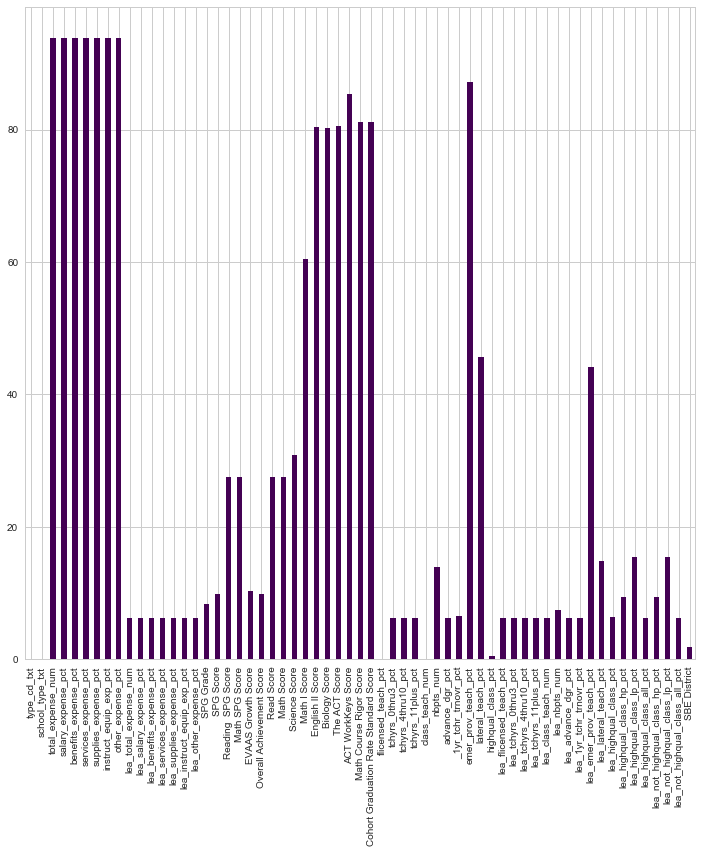

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(style="whitegrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(12,12))
d1.plot(ax = ax, kind = "bar", cmap = "viridis")


## Imputing missing values with the corresponding mean value of the feature

In [80]:
#Mean imputation on district expenditure attributes

NC_data['lea_total_expense_num'].fillna(NC_data['lea_total_expense_num'].mean(), inplace = True)
NC_data['lea_salary_expense_pct'].fillna(NC_data['lea_salary_expense_pct'].mean(), inplace = True)
NC_data['lea_benefits_expense_pct'].fillna(NC_data['lea_benefits_expense_pct'].mean(), inplace = True)
NC_data['lea_services_expense_pct'].fillna(NC_data['lea_services_expense_pct'].mean(), inplace = True)
NC_data['lea_supplies_expense_pct'].fillna(NC_data['lea_supplies_expense_pct'].mean(), inplace = True)
NC_data['lea_instruct_equip_exp_pct'].fillna(NC_data['lea_instruct_equip_exp_pct'].mean(), inplace = True)
NC_data['lea_other_expense_pct'].fillna(NC_data['lea_other_expense_pct'].mean(), inplace = True)



#Mean imputation of missing scores data
NC_data['Reading  SPG Score'].fillna(NC_data['Reading  SPG Score'].mean(), inplace = True) 
NC_data['Math SPG Score'].fillna(NC_data['Math SPG Score'].mean(), inplace = True) 
NC_data['EVAAS Growth Score'].fillna(NC_data['EVAAS Growth Score'].mean(), inplace = True) 
NC_data['Overall Achievement Score'].fillna(NC_data['Overall Achievement Score'].mean(), inplace = True) 
NC_data['Read Score'].fillna(NC_data['Read Score'].mean(), inplace = True) 
NC_data['Math Score'].fillna(NC_data['Math Score'].mean(), inplace = True) 
NC_data['Science Score'].fillna(NC_data['Science Score'].mean(), inplace = True) 



#Teacher features - < 15% missing will be replaced with the mean value
NC_data['flicensed_teach_pct'].fillna(NC_data['flicensed_teach_pct'].mean(), inplace = True)

NC_data['tchyrs_0thru3_pct'].fillna(NC_data['tchyrs_0thru3_pct'].mean(), inplace = True)
NC_data['tchyrs_4thru10_pct'].fillna(NC_data['tchyrs_4thru10_pct'].mean(), inplace = True)
NC_data['tchyrs_11plus_pct'].fillna(NC_data['tchyrs_11plus_pct'].mean(), inplace = True)
NC_data['advance_dgr_pct'].fillna(NC_data['advance_dgr_pct'].mean(), inplace = True)
NC_data['_1yr_tchr_trnovr_pct'].fillna(NC_data['_1yr_tchr_trnovr_pct'].mean(), inplace = True)

NC_data['lea_flicensed_teach_pct'].fillna(NC_data['lea_flicensed_teach_pct'].mean(), inplace = True)
NC_data['lea_tchyrs_0thru3_pct'].fillna(NC_data['lea_tchyrs_0thru3_pct'].mean(), inplace = True)
NC_data['lea_tchyrs_4thru10_pct'].fillna(NC_data['lea_tchyrs_4thru10_pct'].mean(), inplace = True)
NC_data['lea_tchyrs_11plus_pct'].fillna(NC_data['lea_tchyrs_11plus_pct'].mean(), inplace = True)
NC_data['lea_class_teach_num'].fillna(NC_data['lea_class_teach_num'].mean(), inplace = True)
NC_data['lea_nbpts_num'].fillna(NC_data['lea_nbpts_num'].mean(), inplace = True)
NC_data['lea_advance_dgr_pct'].fillna(NC_data['lea_advance_dgr_pct'].mean(), inplace = True)
NC_data['lea_highqual_class_pct'].fillna(NC_data['lea_highqual_class_pct'].mean(), inplace = True)
NC_data['lea_highqual_class_hp_pct'].fillna(NC_data['lea_highqual_class_hp_pct'].mean(), inplace = True)
NC_data['lea_highqual_class_lp_pct'].fillna(NC_data['lea_highqual_class_lp_pct'].mean(), inplace = True)


NC_data['lea_highqual_class_all_pct'].fillna(NC_data['lea_highqual_class_all_pct'].mean(), inplace = True)
NC_data['lea_not_highqual_class_hp_pct'].fillna(NC_data['lea_not_highqual_class_hp_pct'].mean(), inplace = True)
NC_data['lea_not_highqual_class_lp_pct'].fillna(NC_data['lea_not_highqual_class_lp_pct'].mean(), inplace = True)

NC_data['lea_not_highqual_class_all_pct'].fillna(NC_data['lea_not_highqual_class_all_pct'].mean(), inplace = True)

##REmoving the Charter schools.
NC_data = NC_data[NC_data['type_cd_txt'] != 'Charter']

NC_data.info()

C:\Users\jkras\Anaconda3\lib\site-packages\pandas\core\generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2419 entries, 2 to 2420
Data columns (total 61 columns):
type_cd_txt                              2419 non-null object
school_type_txt                          2419 non-null object
total_expense_num                        0 non-null float64
salary_expense_pct                       0 non-null float64
benefits_expense_pct                     0 non-null float64
services_expense_pct                     0 non-null float64
supplies_expense_pct                     0 non-null float64
instruct_equip_exp_pct                   0 non-null float64
other_expense_pct                        0 non-null float64
lea_total_expense_num                    2419 non-null float64
lea_salary_expense_pct                   2419 non-null float64
lea_benefits_expense_pct                 2419 non-null float64
lea_services_expense_pct                 2419 non-null float64
lea_supplies_expense_pct                 2419 non-null float64
lea_instruct_equip_exp_pct        

## Visualize Summary Statistics (range, mode, mean, median, variance,counts) for a subset of attributes

### Mean percentagevalue of SPG Grades across all schools

Grade breakdown is as follows:

A                         85 - 100 points

B                         70 - 84 points

C                         55 - 69 points

D                         40 - 54 points

F                         less than 40 points

SPG Grade
A       90.113924
A+NG    87.929825
B       75.495146
C       61.927273
D       48.358333
F       34.512605
I             NaN
Name: SPG Score, dtype: float64


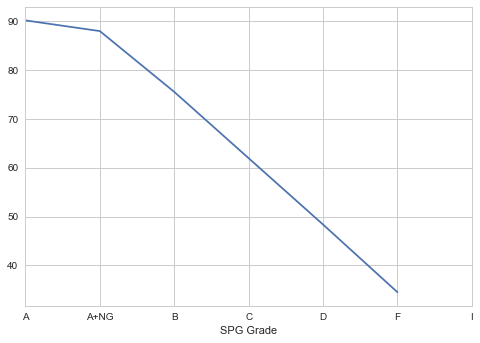

In [81]:
# Visualise how many schools have A,B, C, D and F grade...
import seaborn as sns

score = NC_data.groupby('SPG Grade')['SPG Score'].mean()
print(score)
score.plot()


## Summary Statistics for Numerical Data

In [82]:
NC_data.describe().T
df_grouped = NC_data.groupby(by=['SBE District'])
print (df_grouped.describe())

                             ACT WorkKeys Score  Biology Score  \
SBE District                                                     
North Central Region  count           73.000000      91.000000   
                      mean            72.547945      53.065934   
                      std             13.684989      20.299317   
                      min             33.000000      10.000000   
                      25%             64.000000      37.500000   
                      50%             74.000000      52.000000   
                      75%             83.000000      70.500000   
                      max            100.000000      94.000000   
Northeast Region      count           28.000000      34.000000   
                      mean            66.357143      47.147059   
                      std             12.873212      18.949906   
                      min             33.000000      13.000000   
                      25%             62.250000      31.250000   
          

## Visualizing Relevant Attributes

### Regional differences in average SPG scores and racial composition are registered below

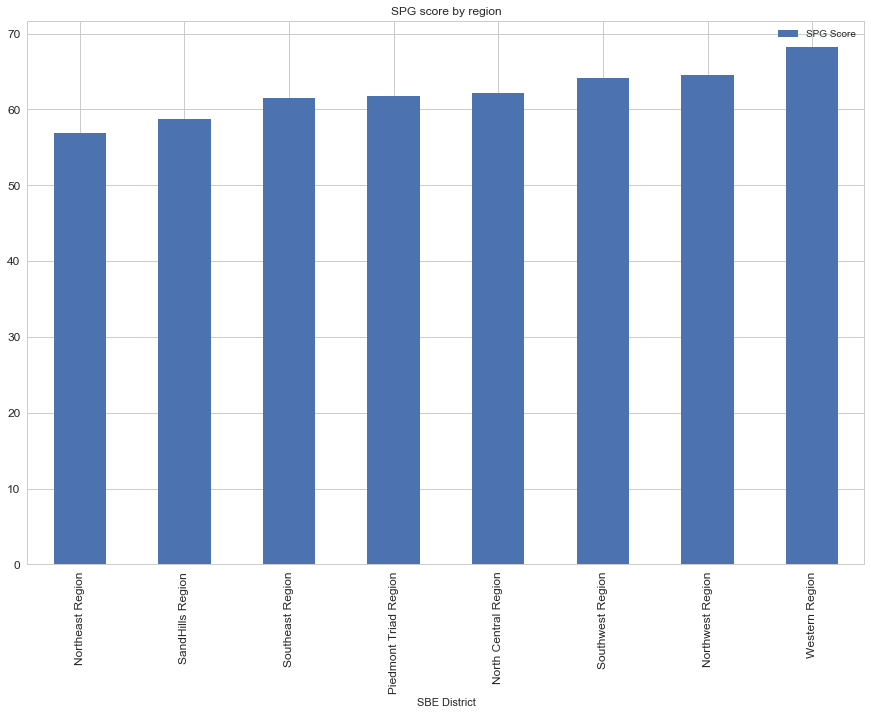

In [83]:
barChart = (schoolData_testRaceRegion.groupby(['SBE District']).agg({'SPG Score':'mean'}))
#barChart.columns = ['SBE District', 'AvgSPGScore']
#.reset_index(name='AvgSPGScore')
barChart

barChart1 = barChart.sort_values('SPG Score')
barChart1
#fig_size = plt.rcParams["figure.figsize"]
barChart1.plot(kind='bar', title ="SPG score by region", figsize=(15, 10), legend=True, fontsize=12)

### Regional differences were likewise identified with counts of schools receiving a particular performance grade

In [84]:
(schoolData_testRaceRegion.groupby(['SBE District', 'SPG Grade']).agg({'SPG Grade':'count'}))

SPG Grade
SBE District          SPG Grade           
North Central Region  A                 17
                      A+NG              21
                      B                127
                      C                192
                      D                123
                      F                 37
Northeast Region      A                  2
                      B                 22
                      C                 61
                      D                 39
                      F                 14
Northwest Region      A                  1
                      A+NG               3
                      B                 43
                      C                 84
                      D                 21
                      F                  1
Piedmont Triad Region A                 15
                      A+NG              14
                      B                 79
                      C                177
                      D                 75
                      F                 27
SandHills Region      A                  8
                      B                 39
                      C                106
                      D                 68
                      F                 19
Southeast Region      A                  9
                      A+NG               5
                      B                 48
                      C                100
                      D                 59
                      F                 11
                      I                  2
Southwest Region      A                 22
                      A+NG              21
                      B                137
                      C                165
                      D                104
                      F                 27
                      I                  2
Western Region        A                  9
                      A+NG               3
                      B                 71
                      C                 81
                      D                 13

## The above data was represented in tabular form. A bar chart visualizes the regional differences.

In [85]:
barChart2 = (schoolData_testRaceRegion.groupby(['SBE District', 'SPG Grade']).agg({'SPG Grade':'count'})).unstack()
barChart2

SPG Grade                                      
SPG Grade                     A  A+NG      B      C      D     F    I
SBE District                                                         
North Central Region       17.0  21.0  127.0  192.0  123.0  37.0  NaN
Northeast Region            2.0   NaN   22.0   61.0   39.0  14.0  NaN
Northwest Region            1.0   3.0   43.0   84.0   21.0   1.0  NaN
Piedmont Triad Region      15.0  14.0   79.0  177.0   75.0  27.0  NaN
SandHills Region            8.0   NaN   39.0  106.0   68.0  19.0  NaN
Southeast Region            9.0   5.0   48.0  100.0   59.0  11.0  2.0
Southwest Region           22.0  21.0  137.0  165.0  104.0  27.0  2.0
Western Region              9.0   3.0   71.0   81.0   13.0   NaN  NaN

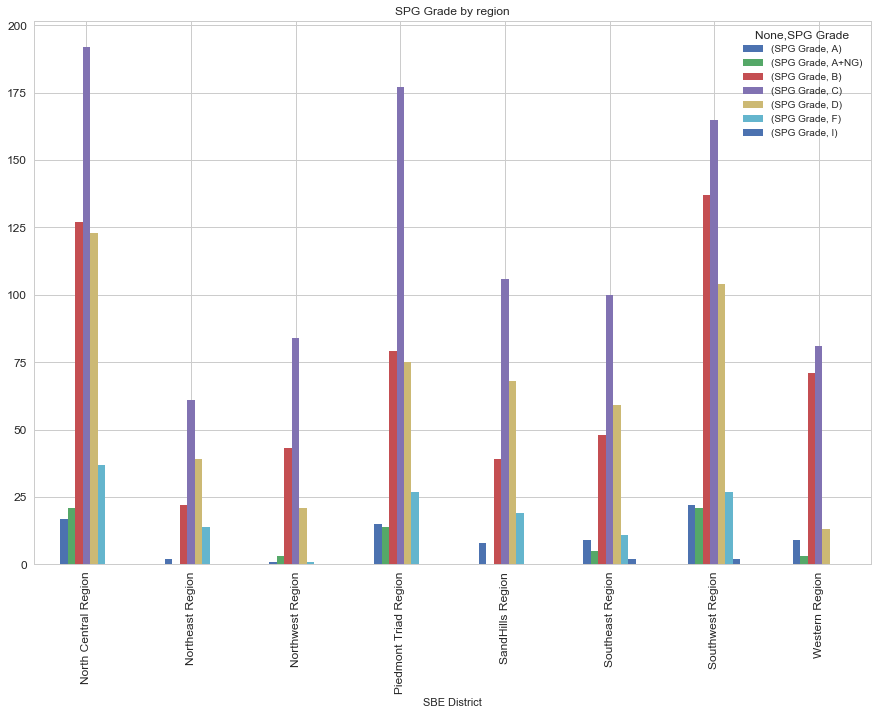

In [86]:
barChart2.plot(kind='bar', title ="SPG Grade by region", figsize=(15, 10), legend=True, fontsize=12)

## Instead of showing count data, a more representative comparison of region-wise differences shows the percentage of schools in a given region receiving a particular SPG Grade. 

### It is worth noting that the Northeast Region has the highest percentage of its schools receiving a failing grade (10% FPerc); the high-performing Western Region has an FPerc value of 0%.

### The SPG Grade percentage values themselves are shown in tabular form, and are represented in the subsequent bar chart

In [87]:
dist_df = schoolData_testRaceRegion[['SBE District', 'SPG Grade']]

In [88]:
from numpy import *
bar2 = dist_df.groupby(['SBE District', 'SPG Grade']).size().unstack()
where_are_NaNs = isnan(bar2)
bar2[where_are_NaNs] = 0
bar2['Total'] = bar2['A']+bar2['A+NG']+bar2['B']+bar2['C']+bar2['D']+bar2['F']+bar2['I']
bar2['APerc'] = (bar2['A'] / bar2['Total'])*100
bar2['A+NGPerc'] = (bar2['A+NG'] / bar2['Total'])*100
bar2['BPerc'] = (bar2['B'] / bar2['Total'])*100
bar2['CPerc'] = (bar2['C'] / bar2['Total'])*100
bar2['DPerc'] = (bar2['D'] / bar2['Total'])*100
bar2['FPerc'] = (bar2['F'] / bar2['Total'])*100
bar2['IPerc'] = (bar2['I'] / bar2['Total'])*100
bar2

SPG Grade,A,A+NG,B,C,D,F,I,Total,APerc,A+NGPerc,BPerc,CPerc,DPerc,FPerc,IPerc
SBE District,,,,,,,,,,,,,,,
North Central Region,17.0,21.0,127.0,192.0,123.0,37.0,0.0,517.0,3.288201,4.061896,24.564797,37.137331,23.791103,7.156673,0.000000
Northeast Region,2.0,0.0,22.0,61.0,39.0,14.0,0.0,138.0,1.449275,0.000000,15.942029,44.202899,28.260870,10.144928,0.000000
Northwest Region,1.0,3.0,43.0,84.0,21.0,1.0,0.0,153.0,0.653595,1.960784,28.104575,54.901961,13.725490,0.653595,0.000000
Piedmont Triad Region,15.0,14.0,79.0,177.0,75.0,27.0,0.0,387.0,3.875969,3.617571,20.413437,45.736434,19.379845,6.976744,0.000000
SandHills Region,8.0,0.0,39.0,106.0,68.0,19.0,0.0,240.0,3.333333,0.000000,16.250000,44.166667,28.333333,7.916667,0.000000
Southeast Region,9.0,5.0,48.0,100.0,59.0,11.0,2.0,234.0,3.846154,2.136752,20.512821,42.735043,25.213675,4.700855,0.854701
Southwest Region,22.0,21.0,137.0,165.0,104.0,27.0,2.0,478.0,4.602510,4.393305,28.661088,34.518828,21.757322,5.648536,0.418410
Western Region,9.0,3.0,71.0,81.0,13.0,0.0,0.0,177.0,5.084746,1.694915,40.112994,45.762712,7.344633,0.000000,0.000000


In [89]:
gradeRegionPlot = bar2
gradeRegionPlot.drop('A', axis=1, inplace=True)
gradeRegionPlot.drop('A+NG', axis=1, inplace=True)
gradeRegionPlot.drop('B', axis=1, inplace=True)
gradeRegionPlot.drop('C', axis=1, inplace=True)
gradeRegionPlot.drop('D', axis=1, inplace=True)
gradeRegionPlot.drop('F', axis=1, inplace=True)
gradeRegionPlot.drop('I', axis=1, inplace=True)
gradeRegionPlot.drop('Total', axis=1, inplace=True)
gradeRegionPlot

SPG Grade,APerc,A+NGPerc,BPerc,CPerc,DPerc,FPerc,IPerc
SBE District,,,,,,,
North Central Region,3.288201,4.061896,24.564797,37.137331,23.791103,7.156673,0.000000
Northeast Region,1.449275,0.000000,15.942029,44.202899,28.260870,10.144928,0.000000
Northwest Region,0.653595,1.960784,28.104575,54.901961,13.725490,0.653595,0.000000
Piedmont Triad Region,3.875969,3.617571,20.413437,45.736434,19.379845,6.976744,0.000000
SandHills Region,3.333333,0.000000,16.250000,44.166667,28.333333,7.916667,0.000000
Southeast Region,3.846154,2.136752,20.512821,42.735043,25.213675,4.700855,0.854701
Southwest Region,4.602510,4.393305,28.661088,34.518828,21.757322,5.648536,0.418410
Western Region,5.084746,1.694915,40.112994,45.762712,7.344633,0.000000,0.000000


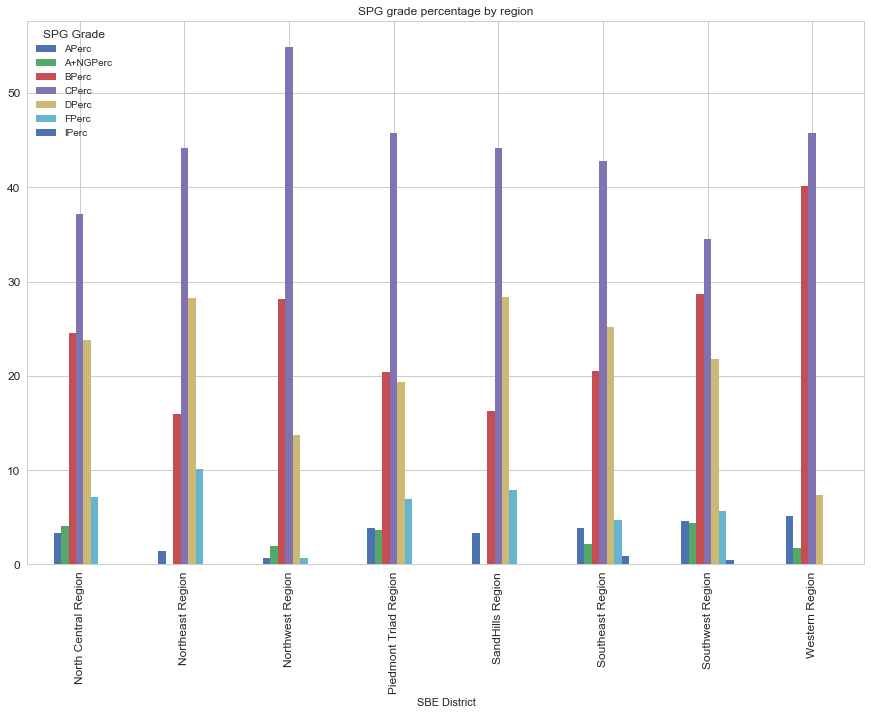

In [90]:
gradeRegionPlot.plot(kind='bar', title ="SPG grade percentage by region", figsize=(15, 10), legend=True, fontsize=12)

## Region-wise racial composition

### A closer look was taken at mean value counts and percentages of the racial demographics of various regions

In [91]:
distRaceData = (schoolData_testRaceRegion.groupby(['SBE District']).agg({'White_RACE':'mean', 'Black_RACE':'mean', 'Hispanic_RACE':'mean','Indian_RACE':'mean','Asian_RACE':'mean','Pacific Island_RACE':'mean','Two or More_RACE':'mean'}))
distRaceData

,White_RACE,Black_RACE,Hispanic_RACE,Indian_RACE,Asian_RACE,Pacific Island_RACE,Two or More_RACE
SBE District,,,,,,,
North Central Region,303.353183,195.811088,137.404517,2.708419,33.934292,0.716632,26.043121
Northeast Region,187.357143,189.610390,40.863636,2.051948,4.064935,0.441558,16.564935
Northwest Region,328.304348,22.760870,63.250000,0.744565,13.869565,0.266304,19.222826
Piedmont Triad Region,279.836930,137.930456,109.364508,1.824940,17.083933,0.599520,22.645084
SandHills Region,172.905138,181.205534,83.703557,52.462451,5.778656,1.355731,28.897233
Southeast Region,319.856522,139.808696,95.630435,2.386957,8.769565,1.108696,28.143478
Southwest Region,337.995726,195.747863,129.790598,2.371795,29.630342,0.743590,23.880342
Western Region,346.233918,27.619883,63.976608,7.052632,4.584795,1.233918,19.561404


In [92]:
distRaceData['Total'] = distRaceData['White_RACE']+distRaceData['Black_RACE']+distRaceData['Hispanic_RACE']+distRaceData['Indian_RACE']+distRaceData['Asian_RACE']+distRaceData['Pacific Island_RACE']+distRaceData['Two or More_RACE']

In [93]:
distRaceData['White_Race_Percent'] = (distRaceData['White_RACE']/distRaceData['Total'])*100
distRaceData['Black_Race_Percent'] = (distRaceData['Black_RACE']/distRaceData['Total'])*100
distRaceData['Hispanic_Race_Percent'] = (distRaceData['Hispanic_RACE']/distRaceData['Total'])*100
distRaceData['Indian_Race_Percent'] = (distRaceData['Indian_RACE']/distRaceData['Total'])*100
distRaceData['Asian_Race_Percent'] = (distRaceData['Asian_RACE']/distRaceData['Total'])*100
distRaceData['Pacific Island_Race_Percent'] = (distRaceData['Pacific Island_RACE']/distRaceData['Total'])*100
distRaceData['Two or More_Race_Percent'] = (distRaceData['Two or More_RACE']/distRaceData['Total'])*100
distRaceDataPlot = distRaceData
distRaceDataPlot.drop('White_RACE', axis=1, inplace=True)
distRaceDataPlot.drop('Black_RACE', axis=1, inplace=True)
distRaceDataPlot.drop('Hispanic_RACE', axis=1, inplace=True)
distRaceDataPlot.drop('Indian_RACE', axis=1, inplace=True)
distRaceDataPlot.drop('Asian_RACE', axis=1, inplace=True)
distRaceDataPlot.drop('Pacific Island_RACE', axis=1, inplace=True)
distRaceDataPlot.drop('Two or More_RACE', axis=1, inplace=True)
distRaceDataPlot.drop('Total', axis=1, inplace=True)
distRaceDataPlot

,White_Race_Percent,Black_Race_Percent,Hispanic_Race_Percent,Indian_Race_Percent,Asian_Race_Percent,Pacific Island_Race_Percent,Two or More_Race_Percent
SBE District,,,,,,,
North Central Region,43.337949,27.974161,19.630023,0.386933,4.847955,0.102380,3.720599
Northeast Region,42.488992,42.999985,9.267086,0.465342,0.921849,0.100137,3.756608
Northwest Region,73.213831,5.075810,14.105128,0.166042,3.092996,0.059387,4.286805
Piedmont Triad Region,49.155827,24.228702,19.210841,0.320567,3.000944,0.105311,3.977809
SandHills Region,32.852444,34.429541,15.903902,9.968007,1.097960,0.257593,5.490552
Southeast Region,53.693837,23.469477,16.053338,0.400695,1.472134,0.186115,4.724404
Southwest Region,46.933405,27.181153,18.022461,0.329343,4.114409,0.103253,3.315976
Western Region,73.625567,5.873282,13.604427,1.499720,0.974942,0.262389,4.159672


### Caucasians are the most populous demographic in all regions except in the Northeast, where students of African descent are most numerous. The Caucasian population is highest in the Western and Northwest regions.

### Students of Indian decent are most populous in the SandHills Region.

### Hispanic students are distributed more evently throughout all regions.

### Asian students are more populous in the North Central, Northwest, Southwest, and Piedmont Regions.


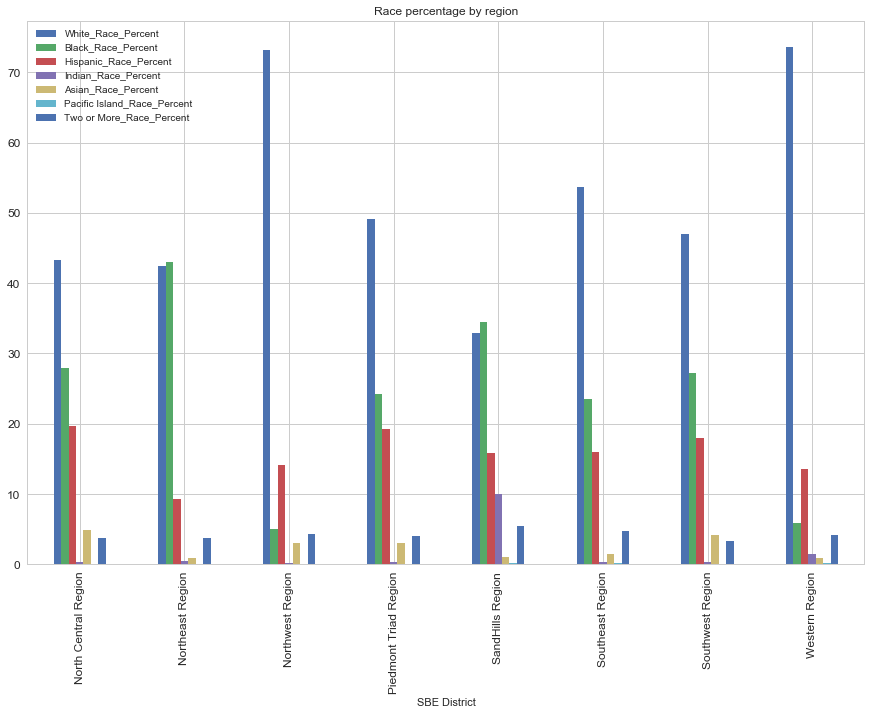

In [94]:
distRaceDataPlot.plot(kind='bar', title ="Race percentage by region", figsize=(15, 10), legend=True, fontsize=12)

## Region-wise differences in the values of attributes concerning teacher qualifications were likewise considered

In [95]:
distQualifiedTeacher = schoolData_testRaceRegion[['SBE District', 'flicensed_teach_pct', 'advance_dgr_pct', 'highqual_class_pct', 'st_flicensed_teach_pct', 'st_advance_dgr_pct', 'st_highqual_class_pct']]
distQualifiedTeacher

,SBE District,flicensed_teach_pct,advance_dgr_pct,highqual_class_pct,st_flicensed_teach_pct,st_advance_dgr_pct,st_highqual_class_pct
0,Southwest Region,0.893,NaN,0.872,0.808,0.277,0.820
1,North Central Region,0.800,NaN,0.909,0.895,0.262,0.894
2,Piedmont Triad Region,1.000,0.143,0.964,0.897,0.248,0.964
3,Piedmont Triad Region,0.958,0.194,1.000,0.975,0.285,0.982
4,Piedmont Triad Region,1.000,0.529,1.000,0.975,0.285,0.982
5,Piedmont Triad Region,0.835,0.230,0.981,0.923,0.268,0.962
6,NaN,0.800,0.067,NaN,0.897,0.248,0.964
7,Piedmont Triad Region,0.956,0.370,1.000,0.975,0.285,0.982
8,Piedmont Triad Region,1.000,0.357,0.952,0.975,0.285,0.982
9,Piedmont Triad Region,0.942,0.143,0.860,0.897,0.248,0.964


In [96]:

distTeacherData = (distQualifiedTeacher.groupby(['SBE District']).agg({'flicensed_teach_pct':'mean', 'advance_dgr_pct':'mean', 'highqual_class_pct':'mean','st_flicensed_teach_pct':'mean','st_advance_dgr_pct':'mean','st_highqual_class_pct':'mean'}))

distTeacherData

,flicensed_teach_pct,advance_dgr_pct,highqual_class_pct,st_flicensed_teach_pct,st_advance_dgr_pct,st_highqual_class_pct
SBE District,,,,,,
North Central Region,0.925557,0.301565,0.949602,0.939504,0.273641,0.964252
Northeast Region,0.889232,0.253310,0.942451,0.933811,0.271500,0.963134
Northwest Region,0.979323,0.310016,0.971053,0.937635,0.273254,0.961540
Piedmont Triad Region,0.942302,0.294597,0.969198,0.938453,0.273872,0.964570
SandHills Region,0.911762,0.247103,0.941908,0.940561,0.273508,0.966389
Southeast Region,0.938708,0.256035,0.957514,0.939156,0.272728,0.965235
Southwest Region,0.928356,0.230386,0.969884,0.939784,0.274244,0.964381
Western Region,0.955989,0.311250,0.969005,0.932946,0.271686,0.959995


## Tables and bar charts show that values of the 'flicensed_teachers' attribute (which represents the percent of fully licensed teachers at a given school) is highest in the Western Region and lowest in the Northeast Region

## Moreover, the percentage of teachers with advanced degrees is highest in the Northwest and Western Regions and lowest in the SandHills, Southwest and Northeast regions. 

## These findings warrant further investigation of correlations between school performance metrics and region-wise differences in teacher qualifications.

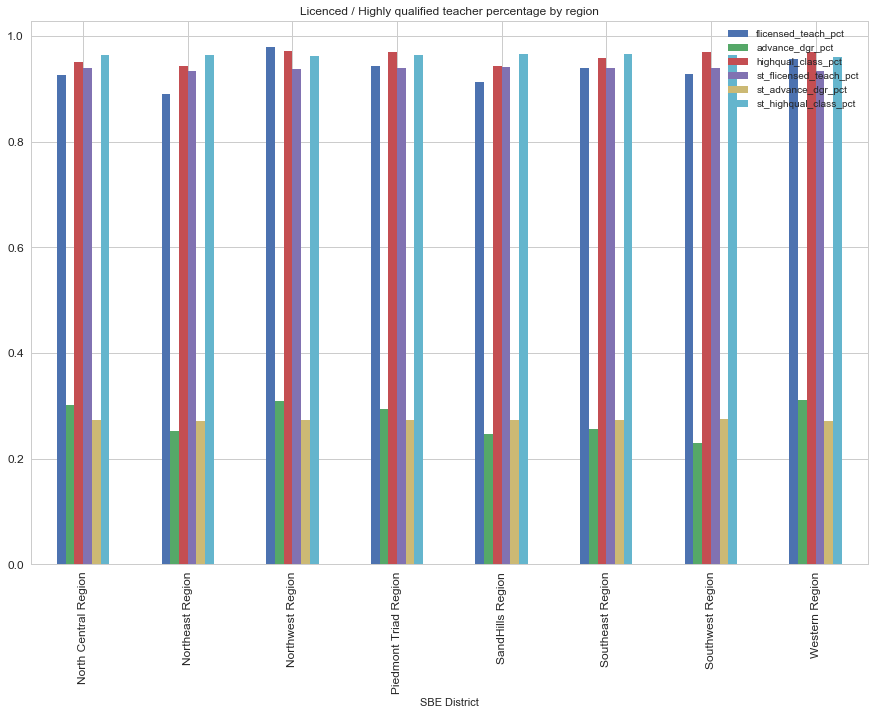

In [97]:
distTeacherData.plot(kind='bar', title ="Licenced / Highly qualified teacher percentage by region", figsize=(15, 10), legend=True, fontsize=12)

## Crime and Suspension Rates across Regions

### Further exploratory analysis concerned the number of short- and long term suspensions, the number of crimes or acts of violence, and the number of explusions per 100 students.

### The figures show that suspension and explusion rates are lowest in the Western and Northwestern Regions.

### Short-term suspension rates are  particularly high in the Northeast, SandHills and Southwest Regions.

In [98]:
distCrimeSuspension = schoolData_testRaceRegion[['SBE District', 'crime_per_c_num','short_susp_per_c_num','long_susp_per_c_num','expelled_per_c_num']]
distCrimeSuspData = (distCrimeSuspension.groupby(['SBE District']).agg({'crime_per_c_num':'mean', 'short_susp_per_c_num':'mean', 'long_susp_per_c_num':'mean','expelled_per_c_num':'mean'}))
distCrimeSuspData

,crime_per_c_num,short_susp_per_c_num,long_susp_per_c_num,expelled_per_c_num
SBE District,,,,
North Central Region,0.931574,15.400130,0.174556,0.000130
Northeast Region,0.542866,27.498049,0.085732,0.000610
Northwest Region,0.693228,8.081481,0.034762,0.000000
Piedmont Triad Region,0.746407,13.139474,0.044188,0.000870
SandHills Region,0.945420,26.070420,0.064122,0.003626
Southeast Region,0.654239,18.790535,0.118683,0.001523
Southwest Region,0.697407,21.245697,0.091081,0.002122
Western Region,0.638432,9.833027,0.055459,0.000000


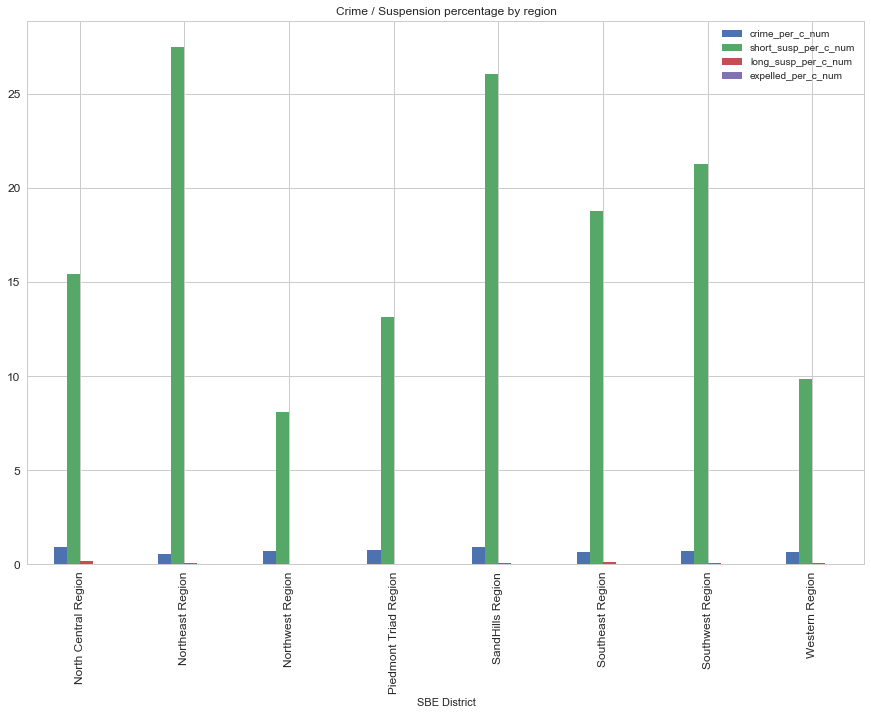

In [99]:
distCrimeSuspData.plot(kind='bar', title ="Crime / Suspension percentage by region", figsize=(15, 10), legend=True, fontsize=12)

### A closer look at the figures concerning teachers with 10+ years of experience shows that the Northwest Region has the highest percentage.

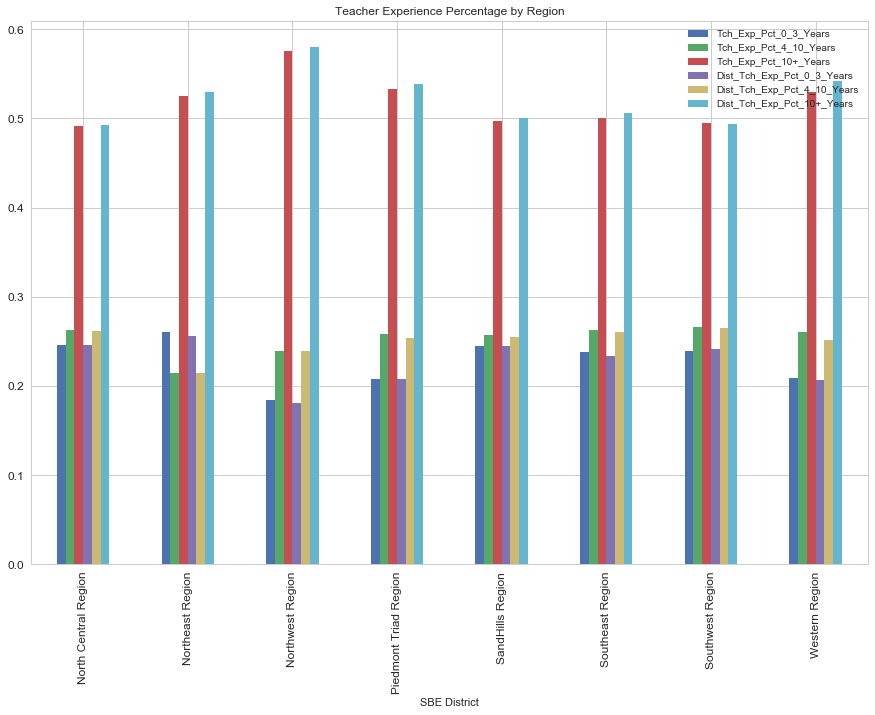

In [100]:
distTeacherExp = schoolData_testRaceRegion[['SBE District', 'Tch_Exp_Pct_0_3_Years','Tch_Exp_Pct_4_10_Years','Tch_Exp_Pct_10+_Years','Dist_Tch_Exp_Pct_0_3_Years','Dist_Tch_Exp_Pct_4_10_Years','Dist_Tch_Exp_Pct_10+_Years']]
distTeacherExpData = (distTeacherExp.groupby(['SBE District']).agg({'Tch_Exp_Pct_0_3_Years':'mean', 'Tch_Exp_Pct_4_10_Years':'mean', 'Tch_Exp_Pct_10+_Years':'mean','Dist_Tch_Exp_Pct_0_3_Years':'mean','Dist_Tch_Exp_Pct_4_10_Years':'mean','Dist_Tch_Exp_Pct_10+_Years':'mean'}))
distTeacherExpData


distTeacherExpData.plot(kind='bar', title ="Teacher Experience Percentage by Region", figsize=(15, 10), legend=True, fontsize=12)

# Visualizing Attribute Relationships

## A first-pass visualization of the relation between expenditure data and  SPG scores showed some weak positive correlation between school performance and salary- and benefits-related expenditures.

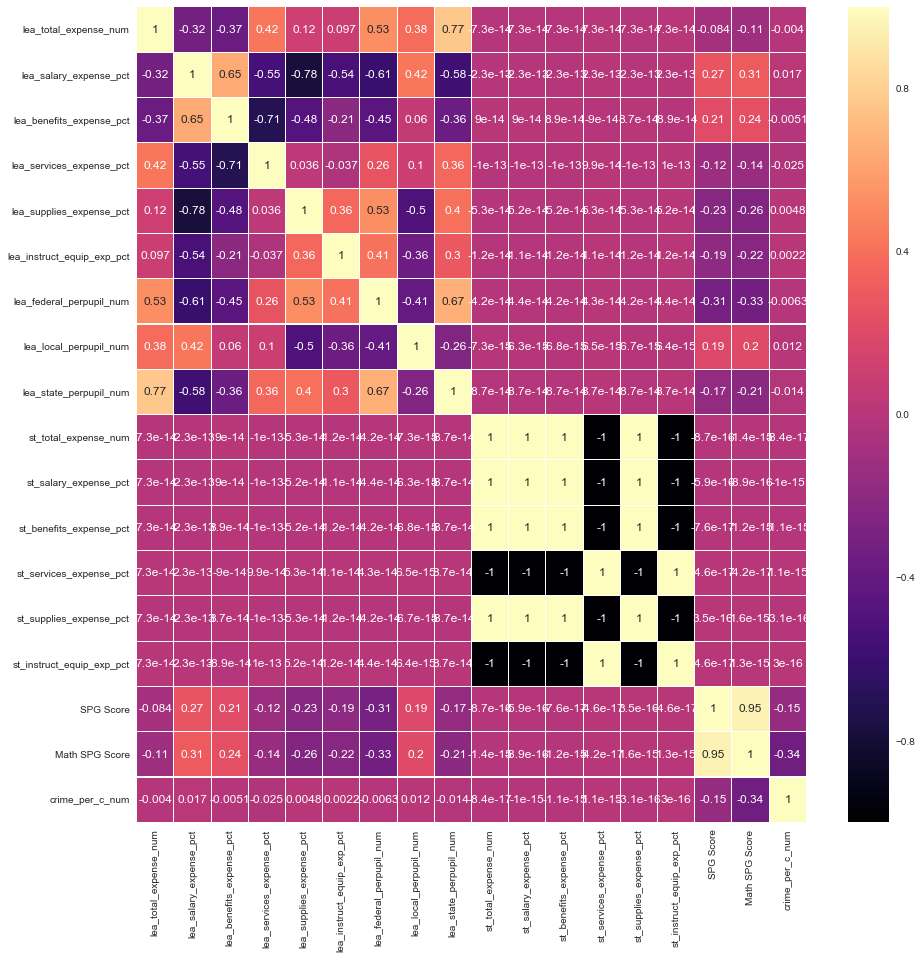

In [101]:
import seaborn as sns

sns.set(style="whitegrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(15, 15))


schoolDataHP1 = schoolData_testRaceRegion[['lea_total_expense_num','lea_salary_expense_pct',
'lea_benefits_expense_pct','lea_services_expense_pct','lea_supplies_expense_pct','lea_instruct_equip_exp_pct',
'lea_federal_perpupil_num','lea_local_perpupil_num','lea_state_perpupil_num',
'st_total_expense_num','st_salary_expense_pct','st_benefits_expense_pct', 'st_services_expense_pct',
'st_supplies_expense_pct','st_instruct_equip_exp_pct','SPG Grade','SPG Score','Reading SPG Grade','Math SPG Grade','Math SPG Score','crime_per_c_num',]]

schoolDataHP1.corr(method = 'pearson')

hm = sns.heatmap(schoolDataHP1.corr(), annot = True, cmap = 'magma', linecolor ='white' , linewidth =0.2)

### Exploratory data analysis involved creating a large heatmap to get a high-level overview of relevant attribute relationships

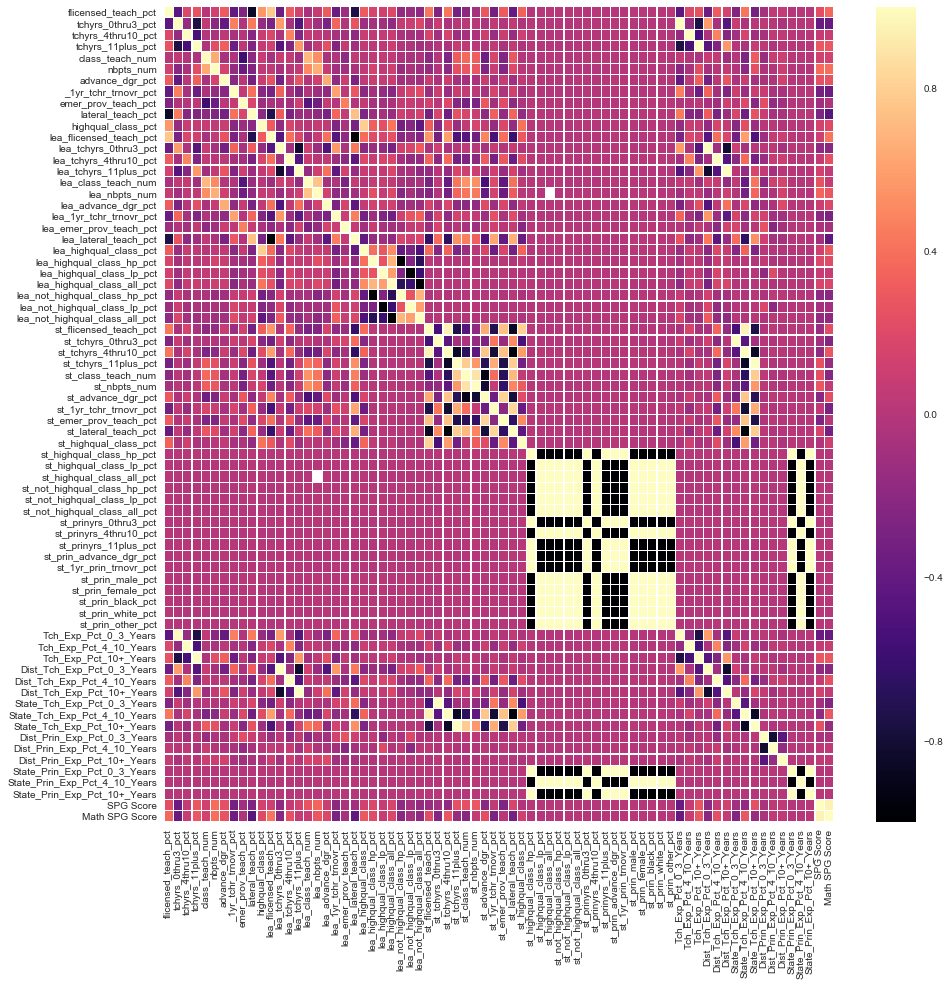

In [102]:
sns.set(style="whitegrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(15, 15))
schoolDataHP2 = schoolData_testRaceRegion[['flicensed_teach_pct','tchyrs_0thru3_pct','tchyrs_4thru10_pct',	'tchyrs_11plus_pct','class_teach_num',
'nbpts_num','advance_dgr_pct','_1yr_tchr_trnovr_pct',	'emer_prov_teach_pct',	'lateral_teach_pct',	'highqual_class_pct',	
'lea_flicensed_teach_pct',	'lea_tchyrs_0thru3_pct',	'lea_tchyrs_4thru10_pct',	'lea_tchyrs_11plus_pct',	'lea_class_teach_num',	
'lea_nbpts_num',	'lea_advance_dgr_pct',	'lea_1yr_tchr_trnovr_pct',	'lea_emer_prov_teach_pct',	'lea_lateral_teach_pct',	'lea_highqual_class_pct',	
'lea_highqual_class_hp_pct',	'lea_highqual_class_lp_pct',	'lea_highqual_class_all_pct',	'lea_not_highqual_class_hp_pct',	'lea_not_highqual_class_lp_pct',	
'lea_not_highqual_class_all_pct',	'st_flicensed_teach_pct',	'st_tchyrs_0thru3_pct',	'st_tchyrs_4thru10_pct',	'st_tchyrs_11plus_pct',	'st_class_teach_num',	
'st_nbpts_num',	'st_advance_dgr_pct',	'st_1yr_tchr_trnovr_pct',	'st_emer_prov_teach_pct',	'st_lateral_teach_pct',	'st_highqual_class_pct',	'st_highqual_class_hp_pct',	
'st_highqual_class_lp_pct',	'st_highqual_class_all_pct',	'st_not_highqual_class_hp_pct',	'st_not_highqual_class_lp_pct',	'st_not_highqual_class_all_pct',	
'st_prinyrs_0thru3_pct',	'st_prinyrs_4thru10_pct',	'st_prinyrs_11plus_pct',	'st_prin_advance_dgr_pct',	'st_1yr_prin_trnovr_pct',	'st_prin_male_pct',	
'st_prin_female_pct',	'st_prin_black_pct',	'st_prin_white_pct',	'st_prin_other_pct',	'Tch_Exp_Pct_0_3_Years',	'Tch_Exp_Pct_4_10_Years',	
'Tch_Exp_Pct_10+_Years',	'Dist_Tch_Exp_Pct_0_3_Years',	'Dist_Tch_Exp_Pct_4_10_Years',	'Dist_Tch_Exp_Pct_10+_Years',	'State_Tch_Exp_Pct_0_3_Years',	
'State_Tch_Exp_Pct_4_10_Years',	'State_Tch_Exp_Pct_10+_Years',	'Dist_Prin_Exp_Pct_0_3_Years',	'Dist_Prin_Exp_Pct_4_10_Years',	'Dist_Prin_Exp_Pct_10+_Years',	
'State_Prin_Exp_Pct_0_3_Years',	'State_Prin_Exp_Pct_4_10_Years',	'State_Prin_Exp_Pct_10+_Years','SPG Grade','SPG Score','Reading SPG Grade','Math SPG Grade','Math SPG Score',]]
schoolDataHP2.corr(method = 'pearson')
hms = sns.heatmap(schoolDataHP2.corr(), annot = False, cmap = 'magma', linecolor ='white' , linewidth =0.2)

## The region-wise analysis warranted a closer investigation of differences between the high-performing Western Region and the low-performing Northeast Region. The first step involved producing correlation heatmaps on performance metrics and teacher qualifications.

### The analysis identified a high level of correlation between SPG Scores and the percentage of teachers who attained their positions with emergency provisions ('emer_prov_teach_pct', 'lea_emer_prov_teach_pct'), suggesting that quickly filling empty positions is important to maintaining and improving performance. This finding was corroborated by the negative correlation between one-year teacher turnover rate ('_1yr_tchr_trnovr_pct rate') and SPG Score. 

### Intuitively, attributes registering the percentage of fully licensed teachers (flicensed_teach_pct,  lea_flicensed_teach_pct) were positively correlated with SPG Score.


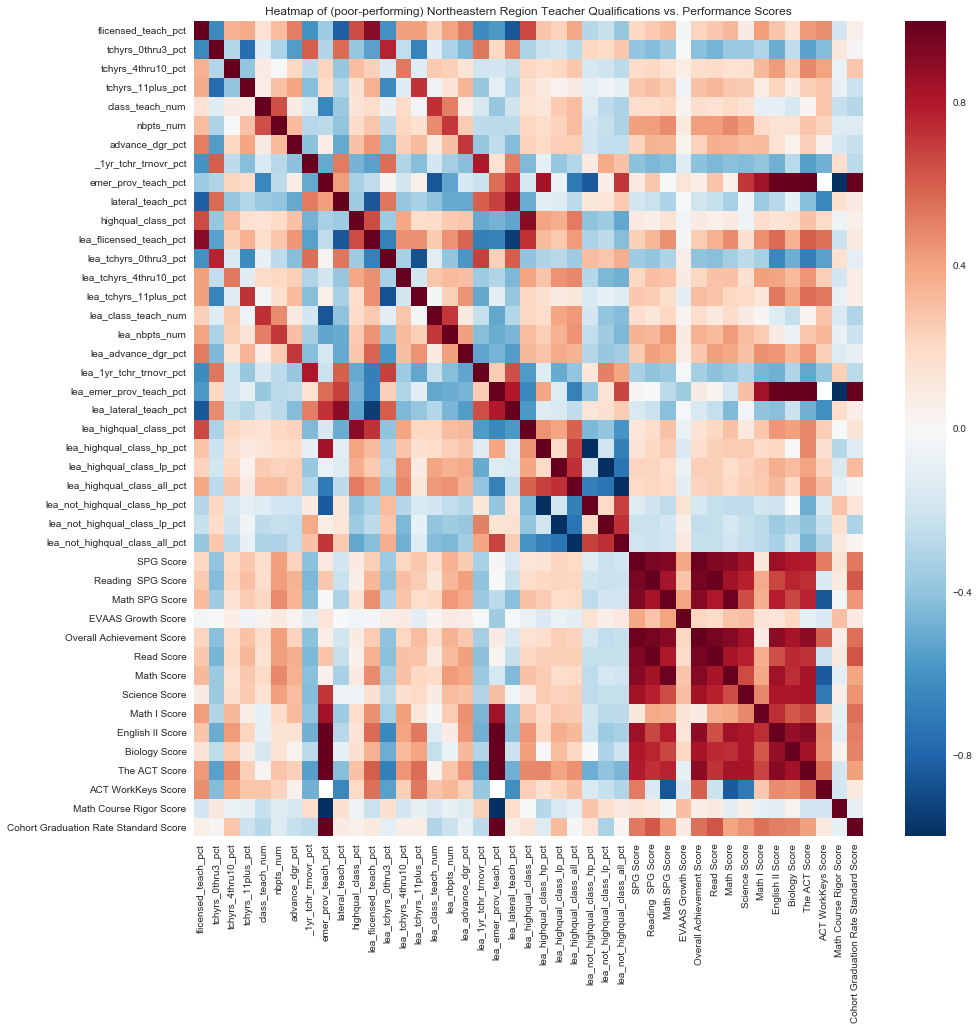

In [103]:
#aliasing completely merged dataframe from the previous merging script 'NC_Educ_Data_All_Merge.py'
all_df = schoolData_testRaceRegion

#subsetting data from the two districts of interest
all_df_NE = all_df[all_df['SBE District'] == 'Northeast Region']
all_df_W = all_df[all_df['SBE District'] == 'Western Region']

#expenditures variable list
exp_list = ['lea_total_expense_num','lea_salary_expense_pct','lea_benefits_expense_pct','lea_services_expense_pct',
'lea_supplies_expense_pct','lea_instruct_equip_exp_pct']

#teacher qualifications variable list
teach_list = ['flicensed_teach_pct', 'tchyrs_0thru3_pct', 'tchyrs_4thru10_pct', 'tchyrs_11plus_pct', 'class_teach_num', 'nbpts_num', 'advance_dgr_pct',
'_1yr_tchr_trnovr_pct', 'emer_prov_teach_pct', 'lateral_teach_pct', 'highqual_class_pct', 'lea_flicensed_teach_pct',
'lea_tchyrs_0thru3_pct', 'lea_tchyrs_4thru10_pct', 'lea_tchyrs_11plus_pct', 'lea_class_teach_num', 'lea_nbpts_num', 'lea_advance_dgr_pct',
'lea_1yr_tchr_trnovr_pct', 'lea_emer_prov_teach_pct', 'lea_lateral_teach_pct', 'lea_highqual_class_pct', 'lea_highqual_class_hp_pct',
'lea_highqual_class_lp_pct', 'lea_highqual_class_all_pct', 'lea_not_highqual_class_hp_pct', 'lea_not_highqual_class_lp_pct',
'lea_not_highqual_class_all_pct']

#performance scores list
grade_list = ['SPG Score', 'Reading  SPG Score', 'Math SPG Score', 'EVAAS Growth Score', 'Overall Achievement Score', 'Read Score', 'Math Score',
'Science Score', 'Math I Score', 'English II Score', 'Biology Score', 'The ACT Score', 'ACT WorkKeys Score', 'Math Course Rigor Score',
'Cohort Graduation Rate Standard Score']

#concatenating lists for comparative heatmaps
hm_list = teach_list + grade_list


#(remember to import seaborn as sns)

#NE region teacher qualification vs. performance scores heatmap
fig, ax = plt.subplots(figsize=(15,15))
hm_corr = all_df_NE[hm_list].corr()
sns.heatmap(hm_corr, ax=ax)
ax.set_title('Heatmap of (poor-performing) Northeastern Region Teacher Qualifications vs. Performance Scores');



## In the Western Region, similar factors seemed to apply to the figures of the correlation heatmap visualizing the relation between teacher qualifications and performance metrics.

## Increasing levels of teacher experience showed a gradation from negative to positive correlation with SPG Scores. Higher percentages of inexperienced teachers (0-3 years) showed a negative correlation; higher percentages of experienced teachers (11+ years) showed a positive correlation.

## Other intutive findings were verified. A higher percentage of classes taught by highly qualified teachers with advanced degrees (lea_highqual_class_all_pct, lea_highqual_class_pct, lea_nbpts_num, advance_dgr_pct) showed a positive corelation with SPG scores. Moreover, higher percentages of teachers acquiring their position through lateral personel transfers (lateral_teach_pct) were correlated with low performance scores. All of the above suggests the importance of having well qualified people in their positions for longer periods of time.


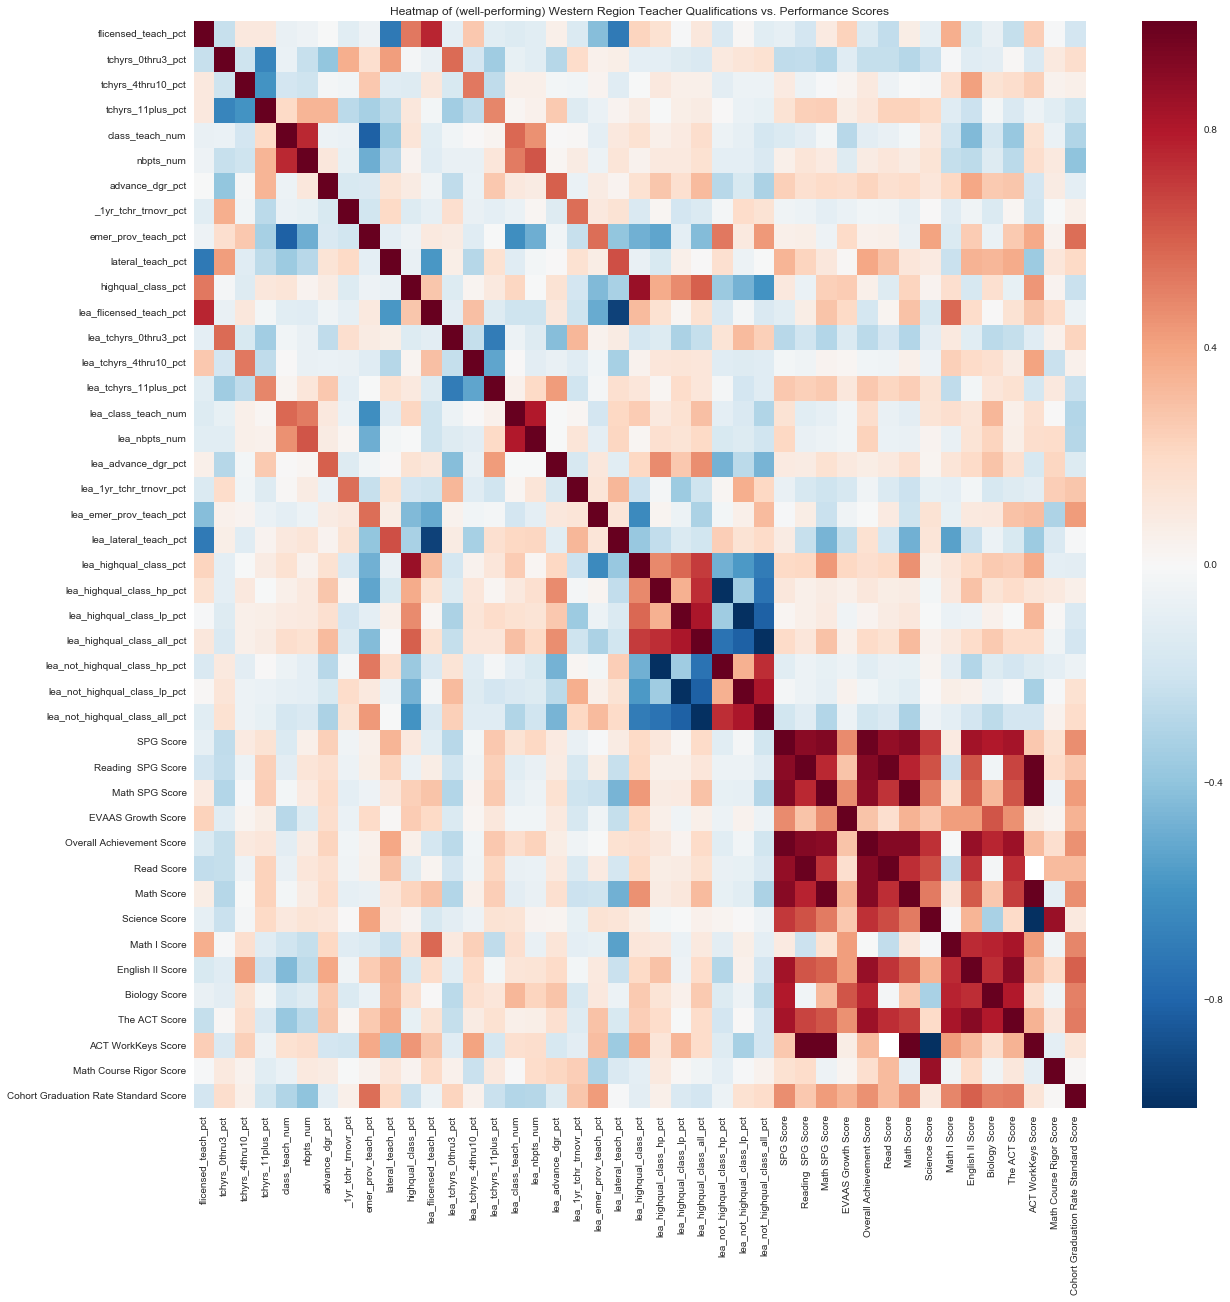

In [104]:
#Western region teacher qualification vs. performance scores heatmap
fig2, ax2 = plt.subplots(figsize=(20,20))
hm_corr2 = all_df_W[hm_list].corr()
sns.heatmap(hm_corr2, ax=ax2)
ax2.set_title('Heatmap of (well-performing) Western Region Teacher Qualifications vs. Performance Scores');



## Correlation heatmaps comparing expenditure data and school performance metrics for the Western and Northeastern Regions showed similar contributing factors of interest.

## Expenditures on salary and benefits were positively correlated with SPG Scores. Meanwhile, expenditures on service supplies and instructional equipment were negatively correlated with SPG Scores. 

## These correlations were present, but relatively weak in the Western Region; by comparison, they were quite strong in the Northeast. This evidence suggests that although similar factors apply across regions, their effects are especially pronounced in poorer performing regions like the Northeast.

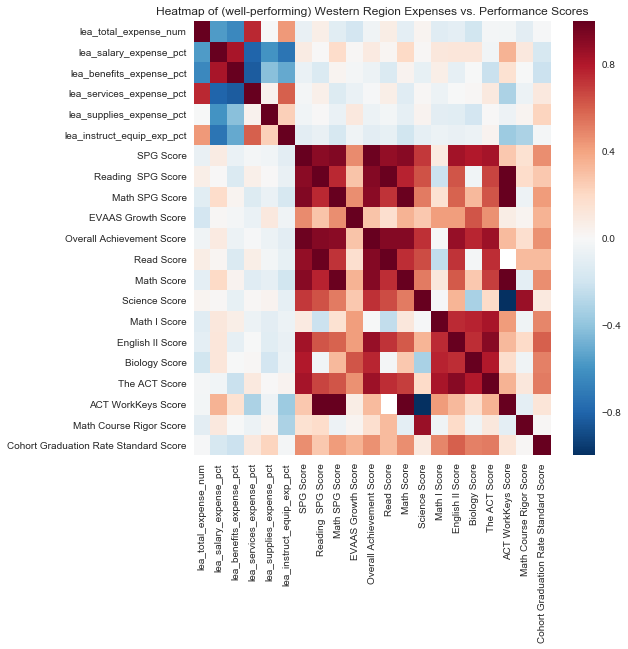

In [105]:
#Western region expenditures vs. performance scores heatmap

hm_list2 = exp_list + grade_list


fig3, ax3 = plt.subplots(figsize=(8,8))
hm_corr3 = all_df_W[hm_list2].corr()
sns.heatmap(hm_corr3, ax=ax3)
ax3.set_title('Heatmap of (well-performing) Western Region Expenses vs. Performance Scores');



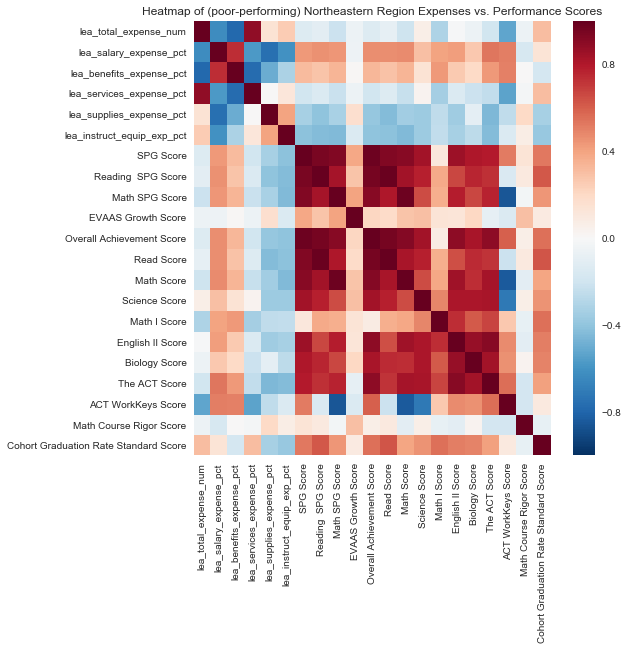

In [106]:
#NE region expenditures vs. performance scores heatmap

hm_list2 = exp_list + grade_list


fig4, ax4 = plt.subplots(figsize=(8,8))
hm_corr4 = all_df_NE[hm_list2].corr()
sns.heatmap(hm_corr4, ax=ax4)
ax4.set_title('Heatmap of (poor-performing) Northeastern Region Expenses vs. Performance Scores');

## New Features

## Follow-up analyses will factor in other economic (poverty and unemployment levels) and demographic (racial composition and parent education) data when further investigating region-wise differences in school performance. Access to data on school performance in previous years should also be considered when drawing conclusions and making recommendations.

# Exceptional Work - PCA and Google Facets

## PCA

### After identifying differences between the Western and Northeastern Regions in SPG Scores, we decided to take a closer look by applying principal component analysis to the expenditure and teacher qualification variables of interest.

### After subsetting the data for the two regions, it was preprocessed with the Scikit-Learn machine learning library to scale the data and mean impute remaining missing values. Plots of the first two principal component loadings were generated. The scatterplot showed greater separation along the axis of the first PC loading, registering high (positive) values for the Northeastern Region, and low (negative) values for the Western Region.

### These differences are registered on the first principal component loading in the heatmap. Variables which registered differences between the high-performing Western Region and the low-performing Northeastern Region included: 

#### 1) those relating to teacher licensing, certifications, and the possession of advanced degrees (lea_nbpts_num, lea_advance_dgr_pct, lea_flicensed_teach_pct);

#### 2) those indicating level of teacher experience and the quality of classes at the district level (tchyrs_0thru3_pct, lea_tchyrs_0thru3_pct, lea_highqual_class_pct, lea_highqual_class_hp_pct, lea_highqual_class_all_pct, lea_not_highqual_class_lp_pct, lea_not_highqual_class_all_pct); 

#### 3) those registering teacher turnover rate and alternative routes to credentialing(_1yr_tchr_trnover_pct, emer_prov_teach_pct, lateral_teach_pct, lea_1yr_tchr_trnovr_pct, lea_emer_prov_teach_pct, lea_lateral_teach_pct); and

#### 4) those relating to expenditures on salary and benefits (lea_benefits_expense_pct, lea_salary_expense_pct).

### These findings were consistent with what was identified in the pairwise heatmap comparison of differences between the Northeastern and Western regions as they pertain to performance metrics like SPG Score.

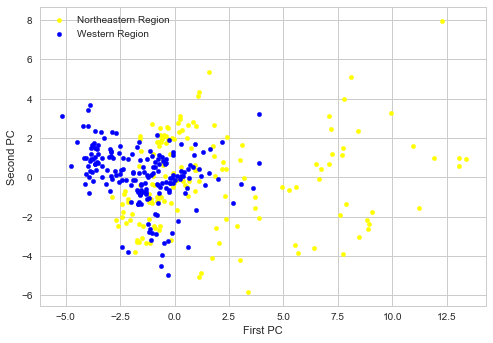

In [107]:
pc_list_nogrades = teach_list + exp_list + ['SBE District']

#concatenate the Northeastern and Western Region dataframes; check for correct shape
df_WandNE = pd.concat([all_df_NE,all_df_W],axis=0)
#df_WandNE.shape

#cast region label to categorical type for integer coding; used below for PCA
df_WandNE['SBE District'] = df_WandNE['SBE District'].astype('category')
df_WandNE['SBE District'] = df_WandNE['SBE District'].cat.codes

#check value counts; Western Region coded to integer '1', Northeastern Region coded to integer '0'
#df_WandNE['SBE District'].value_counts()

#subset concatenated Western and Northeastern Region data with list of variable names of interest; check for correct shape
#pc_df = df_WandNE[pc_list]
#pc_df.shape

pc_df_nogrades = df_WandNE[pc_list_nogrades]

#create flattened dataframe of variable names in the PC list (and check shape); used in PCA below
#flatten_pc_list = pd.DataFrame({'vars':pc_list})
flatten_pc_list = pd.DataFrame({'vars':pc_list_nogrades})
flat_pc_list = flatten_pc_list.values.flatten()
#flat_pc_list.shape

#mean impute NAs of columns used in PCA
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN',strategy='mean',axis=0)
#imp.fit(pc_df)
#imp_data = imp.transform(pc_df)
imp.fit(pc_df_nogrades)
imp_data = imp.transform(pc_df_nogrades)

#after imputation, scale all the data (important for PCA)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(imp_data)
scaled_data = scaler.transform(imp_data)

#perform PCA on scaled data, identifying 6 components; check for correct shape
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
#scaled_data.shape

#plot first two PCs to compare the two regions; note the separation!
pc_1 = x_pca[:,0] #first PC values
pc_2 = x_pca[:,1] #second PC values
pc_region = pc_df_nogrades['SBE District'] #setting region values to temporar variable; necessary for color-coded plot legend
test_pc_df = pd.DataFrame(dict(c0=pc_1,c1=pc_2,c2=pc_region)) #temporary dataframe that combines the first two PC values and the region values; necessary for color-coded plot legend

colors = {1:'blue',0:'yellow'} #map colors to categorical coding of the two regions; 1 = Western Region, 2 = Northeastern Region

#plot PC1 as X, PC2 as Y, using the color mapping of the two regions
fig,ax = plt.subplots()
for key,group in test_pc_df.groupby('c2'):
    group.plot.scatter(ax=ax,x='c0',y='c1',label=key,color=colors[key])

#rename the x and y axis labels
plt.xlabel('First PC')
plt.ylabel('Second PC')

#grab the legend and reset the text of the labels to the corresponding regions; Western = blue, Northeastern = yellow
L = plt.legend()
L.get_texts()[0].set_text('Northeastern Region')
L.get_texts()[1].set_text('Western Region')

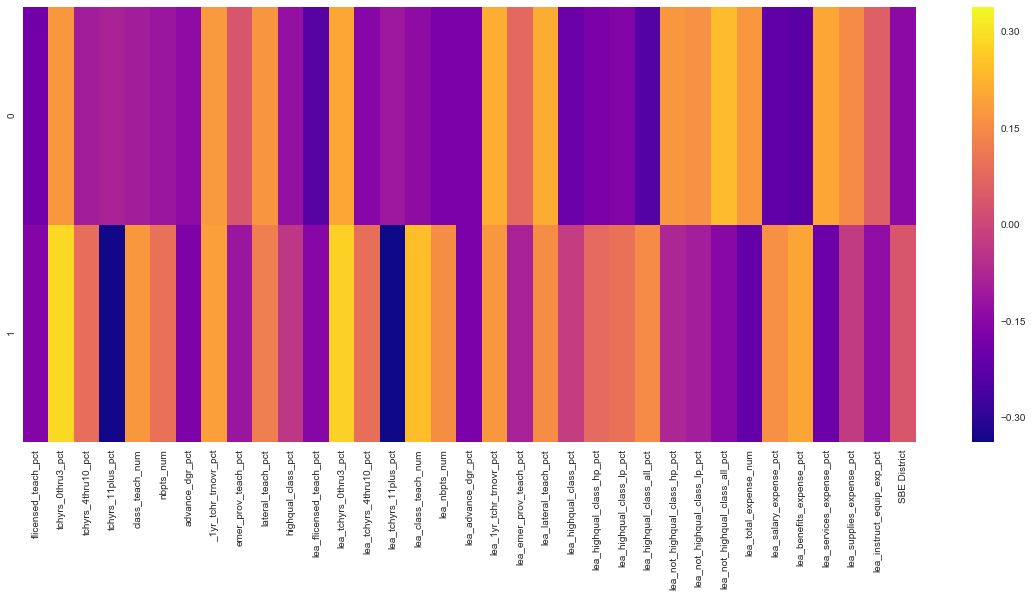

In [108]:
#create dataframe of PC profiles and their corresponding variable names (from the flattened pc_list above)
df_comp = pd.DataFrame(pca.components_,columns=flat_pc_list)

#check PC profiles if desired
#with pd.option_context('display.max_columns', None):
#    print(df_comp)

#heatmap of profiles for the six PCs
plt.figure(figsize=(20,8))
sns.heatmap(df_comp,cmap='plasma')

# Google Facets

## Final visualizations exploring racial composition were created using the Google Facets API

## The below figure shows more students of Asian descent in attendance at schools receiving higher SPG Scores.

![GoogleFacetsAsianData.JPG](attachment:GoogleFacetsAsianData.JPG)

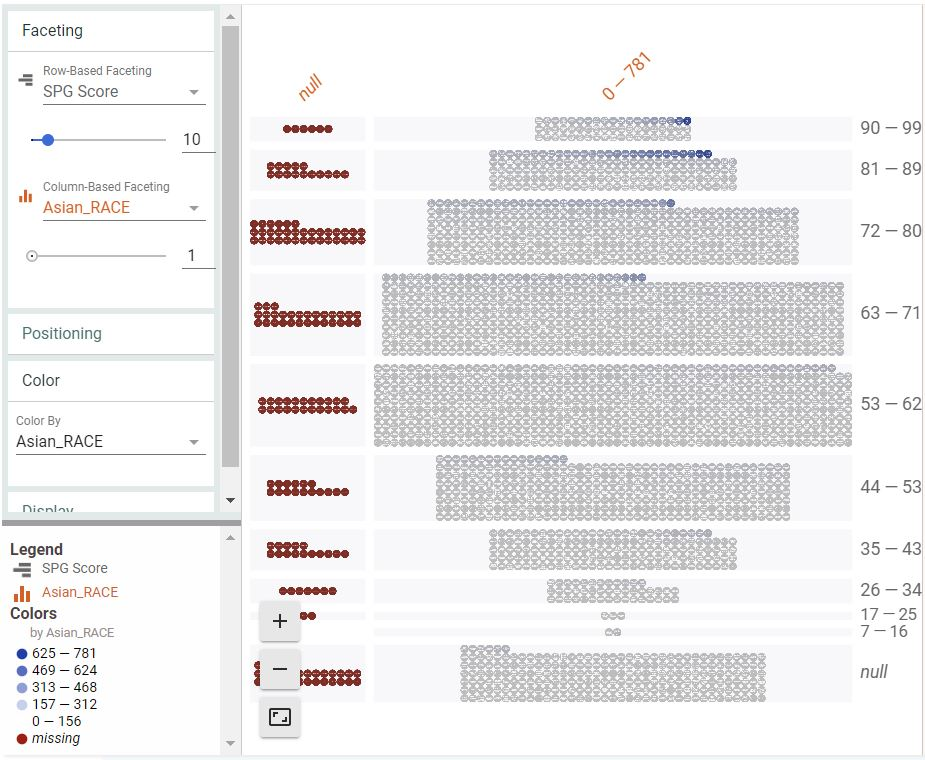

In [110]:
from IPython.display import Image
Image(filename="./Lab_1_Visualizations/GoogleFacetsAsianData.JPG")

## Lastly, the figure below shows an increasing Caucasian majority at schools with higher SPG Scores.

![GoogleFacetsWhitRaceData.JPG](attachment:GoogleFacetsWhitRaceData.JPG)

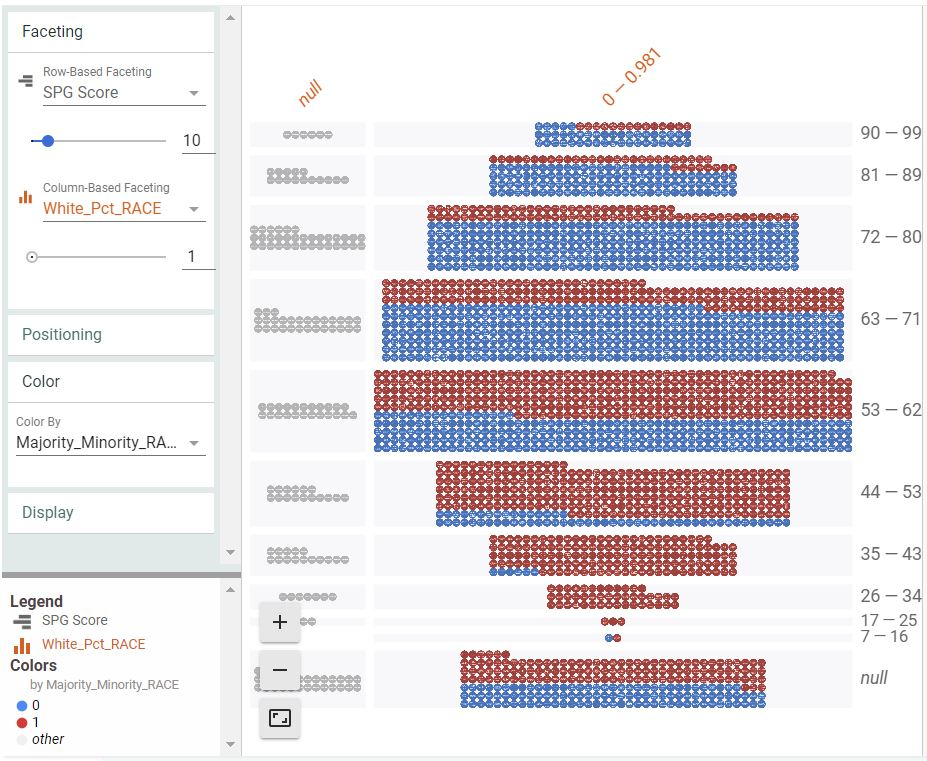

In [111]:
from IPython.display import Image
Image(filename="./Lab_1_Visualizations/GoogleFacetsWhitRaceData.JPG")

## References:

North Carolina Data http://www.ncpublicschools.org/src/researchers/<br />
Professor Jake's Data https://github.com/jakemdrew/EducationDataNC<br />
SPG Info http://www.ncpublicschools.org/docs/accountability/reporting/spgbckgrndpack15.pdf<br />